In [ ]:
import os
import sys

import torch
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.decomposition import PCA
import numpy as np

# This notebook assumes execution from the project root.
# It explicitly sets cwd to external/genomic-FM so GV-Rep loaders work.

os.chdir("../external/genomic-FM")
sys.path.append(".")

Layer    | Feature         | REF Mean   | ALT Mean   | Delta AUC 
-----------------------------------------------------------------
1        | Locality        | 0.0026 | 0.0026 | 0.500
1        | Entropy         | 6.1694 | 6.1697 | 0.500
1        | ShortRange      | 0.0273 | 0.0273 | 0.500
1        | LongRange       | 0.7776 | 0.7776 | 0.500
1        | DistRatio       | 28.5055 | 28.4933 | 0.458
1        | Hubness         | 1.8497 | 1.8507 | 0.638
-->      | LAYER TOTAL     | -          | -          | 0.488

9        | Locality        | 0.0740 | 0.0740 | 0.500
9        | Entropy         | 4.6184 | 4.6190 | 0.722
9        | ShortRange      | 0.4627 | 0.4627 | 0.500
9        | LongRange       | 0.2624 | 0.2625 | 0.500
9        | DistRatio       | 0.5687 | 0.5689 | 0.500
9        | Hubness         | 2.1370 | 2.1465 | 0.528
-->      | LAYER TOTAL     | -          | -          | 0.711

18       | Locality        | 0.0441 | 0.0441 | 0.500
18       | Entropy         | 4.4089 | 4.4108 | 0.543


/var/folders/zb/p41gp_m56t14dq5sdzffcz9m0000gn/T/ipykernel_90375/1386218717.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=total_df, x="Layer", y="AUC", palette="viridis", ax=ax1)


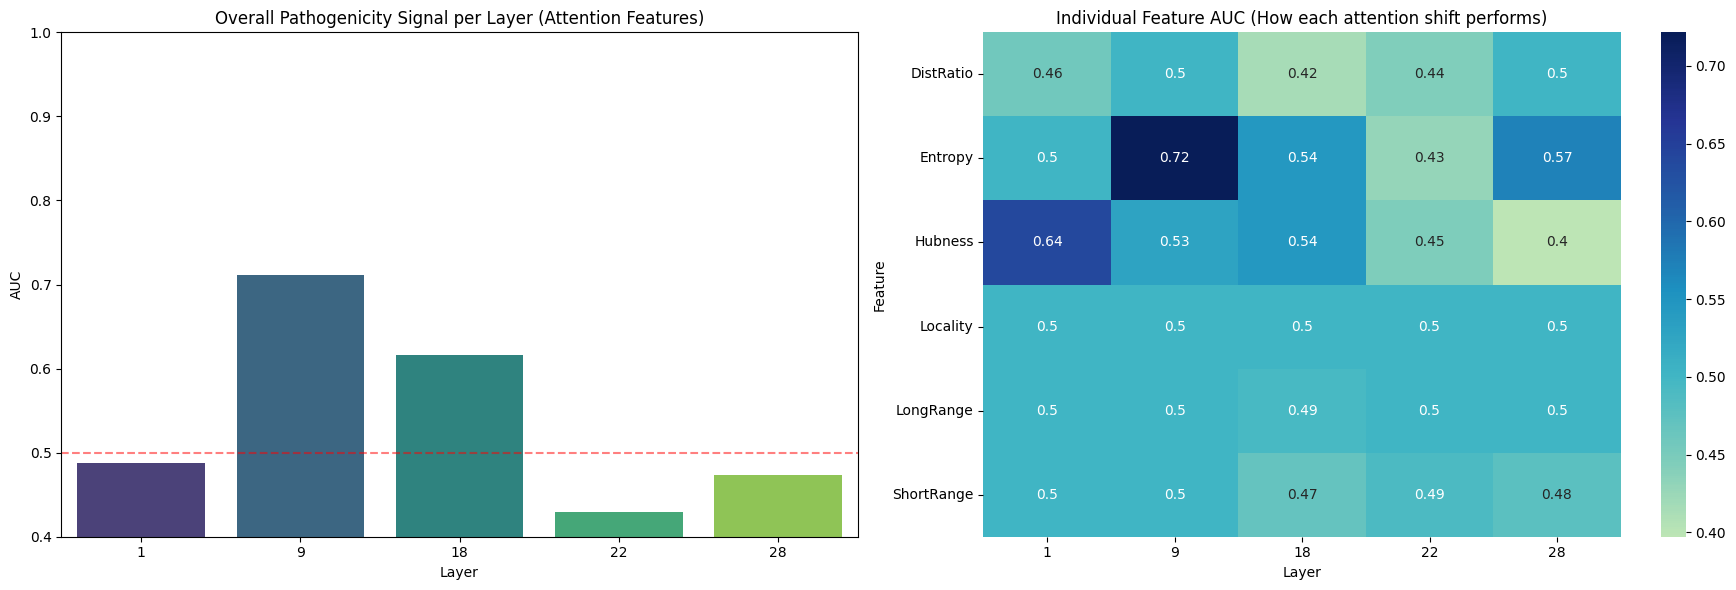

In [ ]:
path = "root/data/clinvar_attentions__n155__bp3000__tok505__layers5__heads_mean.pt"
payload = torch.load(path, map_location="cpu")

layers = payload["layers"]
labels = np.array(payload["labels"])
attn_by_layer = payload["attentions_by_layer"]  


def extract_attention_features(A): # Doesn't really work yet, 
    """
    Collapses (N, L, L) attention matrices into interpretable scalar features.
    A should be a numpy array or torch tensor.
    """
    N, L, _ = A.shape
    features = []

    for i in range(N):
        mat = A[i]
        # 1. Locality: Diagonal Mass
        diag_mask = np.eye(L, dtype=bool)
        diag_mass = mat[diag_mask].sum()
        off_diag_mass = mat.sum() - diag_mass
        locality_ratio = diag_mass / (off_diag_mass + 1e-9)

        # 2. Entropy (Concentration)
        # Higher entropy = spread out; Lower = focused
        row_entropies = [entropy(row + 1e-9) for row in mat]
        avg_entropy = np.mean(row_entropies)

        # 3. Distance Profile (Short vs Long Range)
        # Create a distance matrix d[i,j] = |i-j|
        dist_indices = np.abs(np.arange(L)[:, None] - np.arange(L))
        short_range = mat[dist_indices <= 5].sum() / L
        long_range = mat[dist_indices >= 50].sum() / L
        dist_ratio = long_range / (short_range + 1e-9)

        # 4. Hubness (Max attention received by any one token)
        col_sums = mat.sum(axis=0)
        hubness = np.max(col_sums) / (np.mean(col_sums) + 1e-9)

        features.append([
            locality_ratio, avg_entropy, short_range, 
            long_range, dist_ratio, hubness
        ])

    return np.array(features)


selected_layers = [1,9,18,22, 28]
N = len(labels)
mask = np.isin(labels, ["Class 1", "Class 5"])
y_bin = (labels[mask] == "Class 5").astype(int)

results = []
import seaborn as sns

all_layer_data = []

# --- Main Analysis Cell ---
print(f"{'Layer':<8} | {'Feature':<15} | {'REF Mean':<10} | {'ALT Mean':<10} | {'Delta AUC':<10}")
print("-" * 65)

for l in selected_layers:
    A = attn_by_layer[l]
    if torch.is_tensor(A): A = A.detach().cpu().numpy()
    
    A_ref = A[:N][mask]; A_alt = A[N:][mask]
    feat_ref = extract_attention_features(A_ref)
    feat_alt = extract_attention_features(A_alt)
    feat_delta = feat_alt - feat_ref
    
    feature_names = ["Locality", "Entropy", "ShortRange", "LongRange", "DistRatio", "Hubness"]
    
    layer_feature_aucs = []
    for f_idx, name in enumerate(feature_names):
        X = feat_delta[:, f_idx].reshape(-1, 1)
        clf = LogisticRegression(class_weight="balanced")
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        try:
            auc = cross_val_score(clf, X, y_bin, cv=cv, scoring='roc_auc').mean()
        except:
            auc = 0.5
            
        print(f"{l:<8} | {name:<15} | {feat_ref[:, f_idx].mean():.4f} | {feat_alt[:, f_idx].mean():.4f} | {auc:.3f}")
        
        # Store for graphing
        all_layer_data.append({"Layer": l, "Feature": name, "AUC": auc})
        layer_feature_aucs.append(auc)
        
    # Multi-variate probe
    X_all = StandardScaler().fit_transform(feat_delta)
    full_auc = cross_val_score(LogisticRegression(class_weight="balanced"), X_all, y_bin, cv=cv, scoring='roc_auc').mean()
    all_layer_data.append({"Layer": l, "Feature": "TOTAL", "AUC": full_auc})
    print(f"{'-->':<8} | {'LAYER TOTAL':<15} | {'-':<10} | {'-':<10} | {full_auc:.3f}\n")


import pandas as pd
df_results = pd.DataFrame(all_layer_data)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Graph A: Overall Layer Performance
total_df = df_results[df_results["Feature"] == "TOTAL"]
sns.barplot(data=total_df, x="Layer", y="AUC", palette="viridis", ax=ax1)
ax1.axhline(0.5, ls='--', color='red', alpha=0.5)
ax1.set_title("Overall Pathogenicity Signal per Layer (Attention Features)")
ax1.set_ylim(0.4, 1.0)

# Graph B: Feature Importance Heatmap
pivot_df = df_results[df_results["Feature"] != "TOTAL"].pivot(index="Feature", columns="Layer", values="AUC")
sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", center=0.5, ax=ax2)
ax2.set_title("Individual Feature AUC (How each attention shift performs)")

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_variant_attention(attn_payload, variant_idx, layer, label, token_offset=0):
    N = len(attn_payload["labels"])
    A_all = attn_payload["attentions_by_layer"][layer]
    
    A_ref = A_all[variant_idx]
    A_alt = A_all[variant_idx + N]
    
    delta_attn = A_alt - A_ref
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Heatmap of the shift
    sns.heatmap(delta_attn, cmap="RdBu_r", center=0, ax=axes[0])
    axes[0].set_title(f"Attention Shift (ALT - REF)\nLayer {layer} | {label} Variant")
    axes[0].set_xlabel("Key (Target Token)")
    axes[0].set_ylabel("Query (Source Token)")

    # 2. 1D Attention Profile to the Mutation Site
    mut_token = delta_attn.shape[0] // 2 
    mut_profile_ref = A_ref[:, mut_token]
    mut_profile_alt = A_alt[:, mut_token]
    
    axes[1].plot(mut_profile_ref, label="Ref Attention", color="gray", alpha=0.6)
    axes[1].plot(mut_profile_alt, label="Alt Attention", color="red")
    axes[1].axvline(x=mut_token, color='black', linestyle='--', label="Mutation Site")
    axes[1].set_title(f"Attention Profile to Mutation Site")
    axes[1].set_xlabel("Sequence Position (Tokens)")
    axes[1].set_ylabel("Attention Weight")
    axes[1].legend()
    plt.tight_layout()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_variant_attention(attn_payload, variant_idx, layer, label, token_offset=0):
    """
    Plots Ref Map, Alt Map, Delta Map, and 1D Profile in a single row.
    """
    N = len(attn_payload["labels"])
    A_all = attn_payload["attentions_by_layer"][layer]
    
    A_ref = A_all[variant_idx]
    A_alt = A_all[variant_idx + N]
    delta_attn = A_alt - A_ref
    
    fig, axes = plt.subplots(1, 4, figsize=(24, 5))
    fig.suptitle(f"Layer {layer} | {label} Variant Analysis", fontsize=18, y=1.02)
    
    # 1. Reference Attention Map
    sns.heatmap(A_ref, cmap="viridis", ax=axes[0], cbar_kws={'label': 'Weight'})
    axes[0].set_title(f"Ref Attention")
    
    # 2. Alternate Attention Map
    sns.heatmap(A_alt, cmap="viridis", ax=axes[1], cbar_kws={'label': 'Weight'})
    axes[1].set_title(f"Alt Attention")

    # 3. Delta Map (The shift)
    sns.heatmap(delta_attn, cmap="RdBu_r", center=0, ax=axes[2], cbar_kws={'label': '$\Delta$ Weight'})
    axes[2].set_title("Shift (ALT - REF)")

    # 4. 1D Attention Profile to Mutation Site
    mut_token = delta_attn.shape[0] // 2 
    axes[3].plot(A_ref[:, mut_token], label="Ref", color="gray", alpha=0.6)
    axes[3].plot(A_alt[:, mut_token], label="Alt", color="red")
    axes[3].axvline(x=mut_token, color='black', linestyle='--', alpha=0.5)
    axes[3].set_title("Profile to Mutation Site")
    axes[3].legend()

    for i in range(3):
        axes[i].set_xlabel("Key")
        axes[i].set_ylabel("Query")
        
    plt.tight_layout()
    plt.show()

#### BENIGN LAYER 1

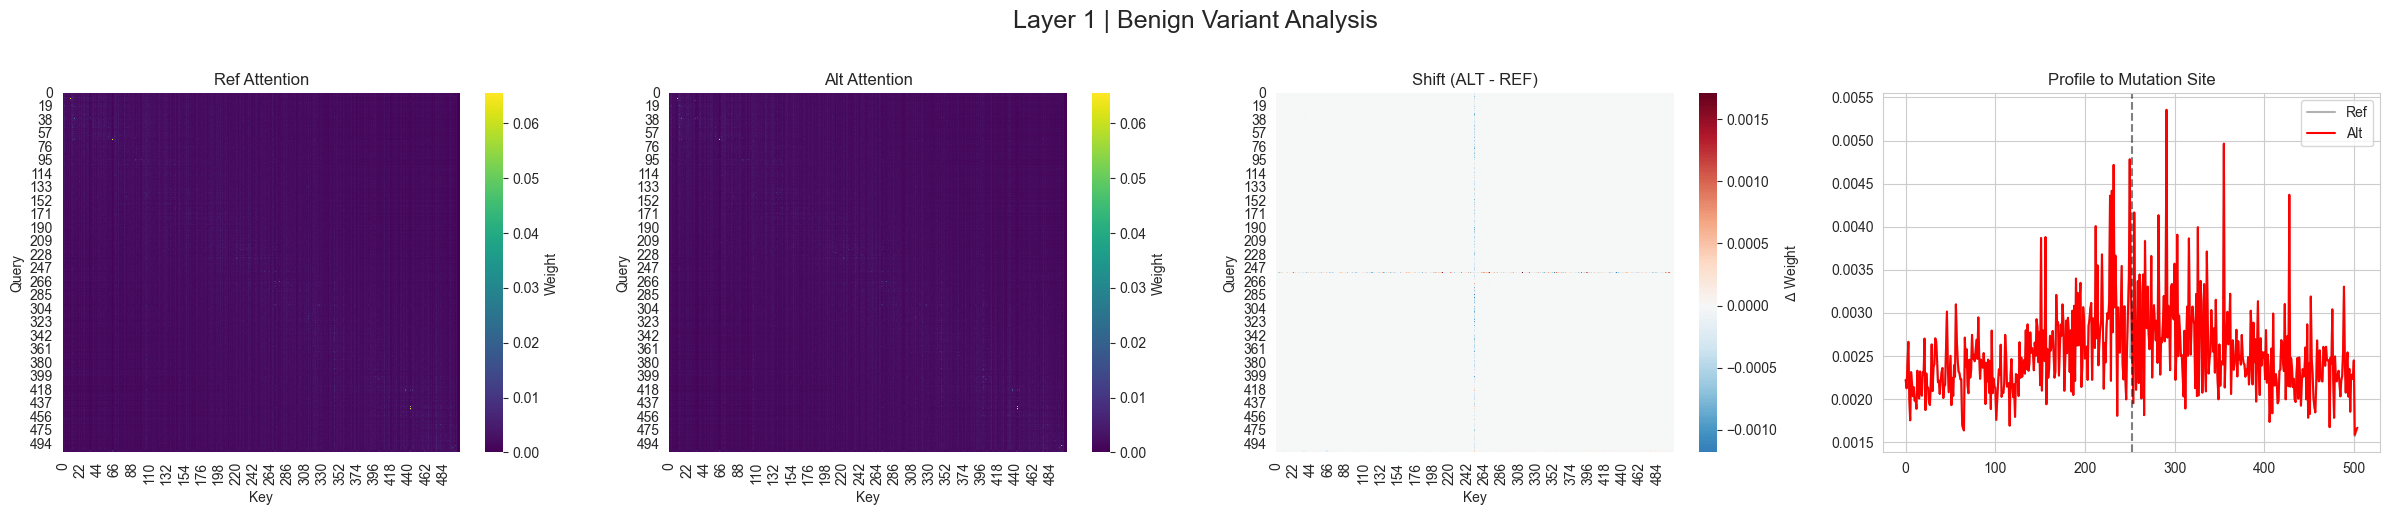

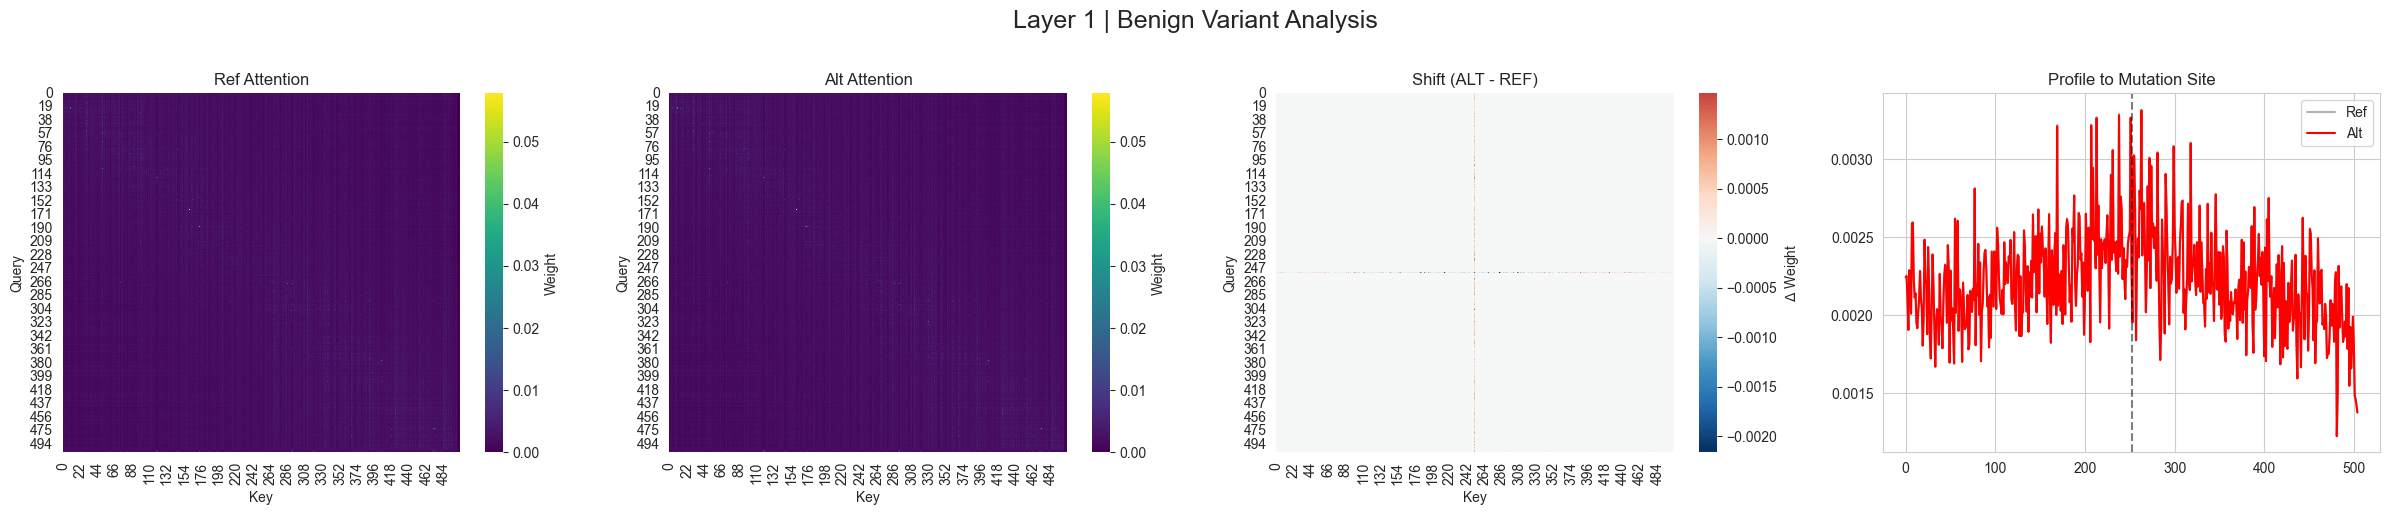

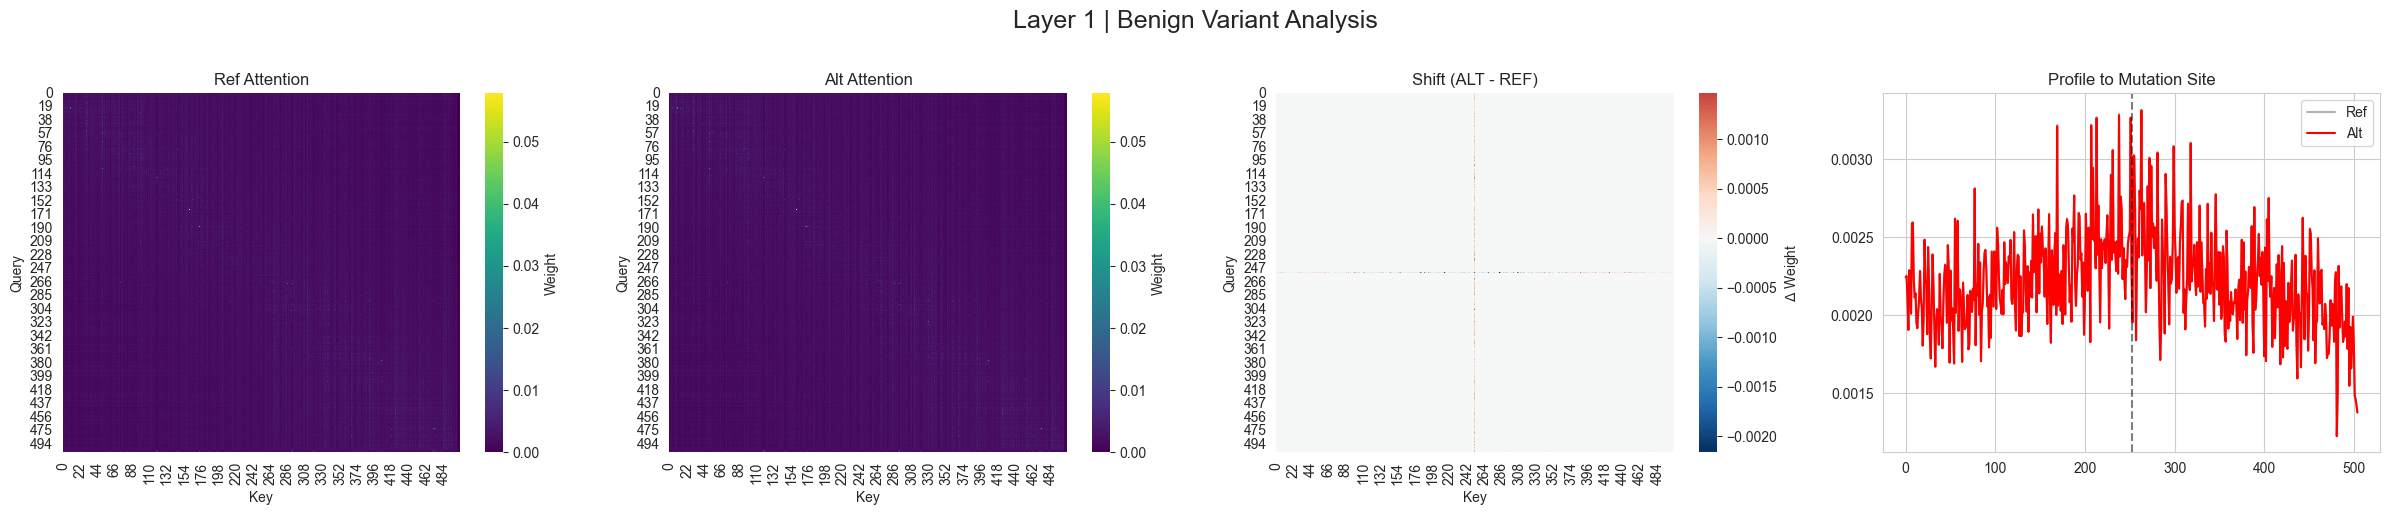

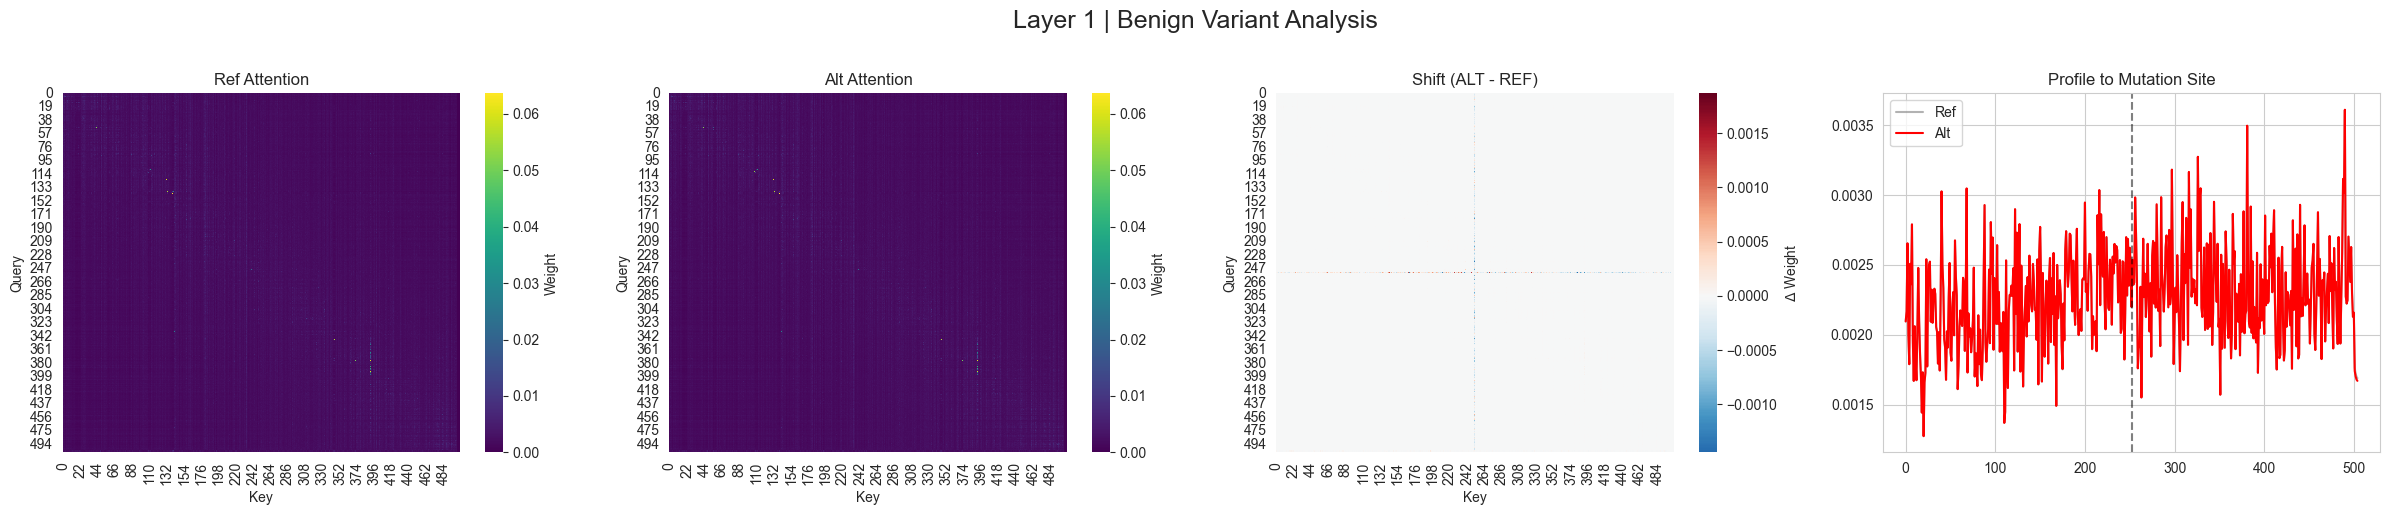

In [23]:
visualize_variant_attention(payload, variant_idx=1, layer=1, label="Benign")
visualize_variant_attention(payload, variant_idx=2, layer=1, label="Benign")
visualize_variant_attention(payload, variant_idx=3, layer=1, label="Benign")
visualize_variant_attention(payload, variant_idx=4, layer=1, label="Benign")

#### PATHOGENIC LAYER 1

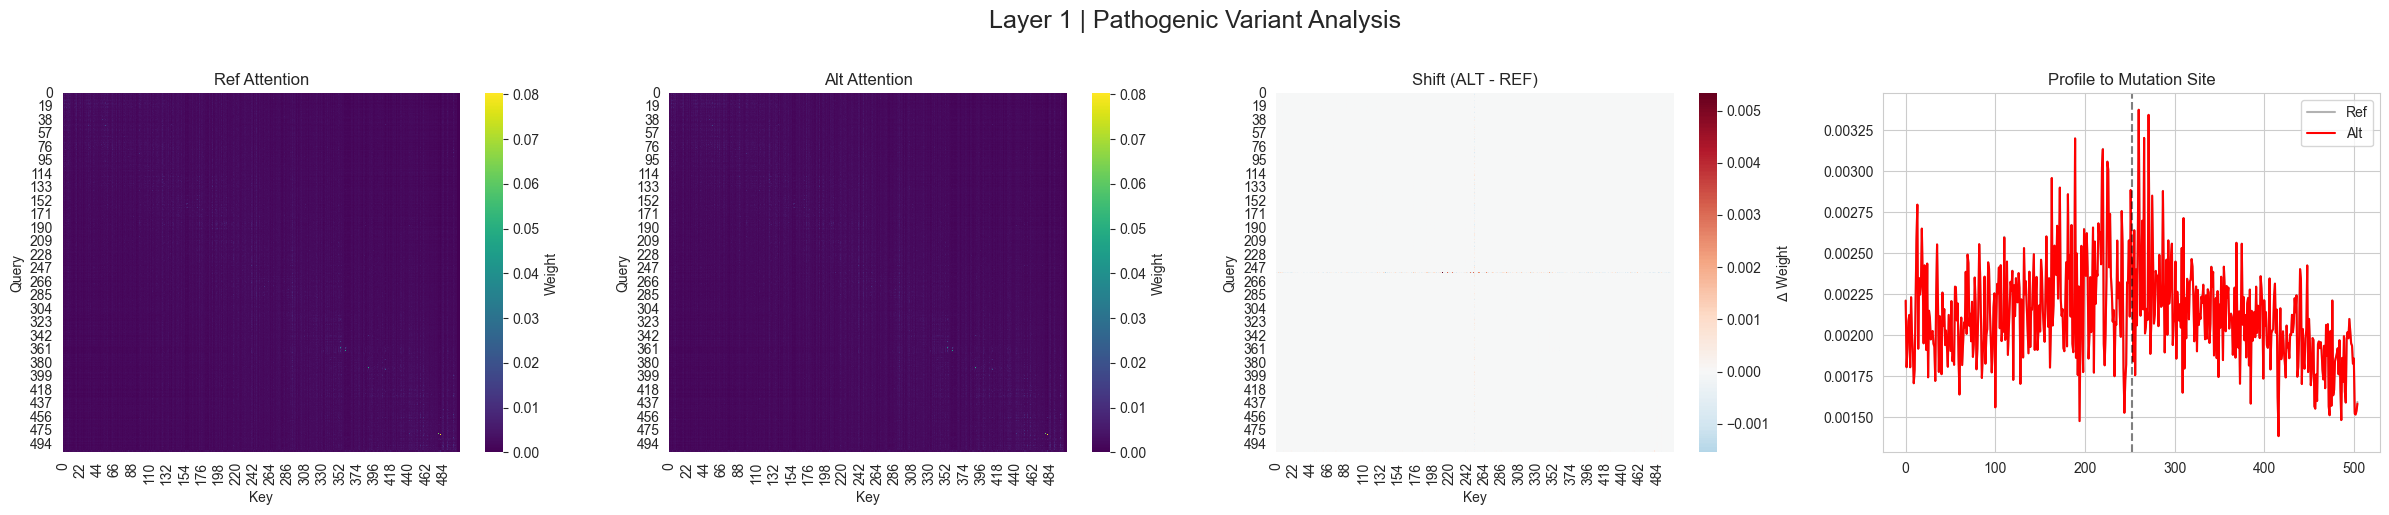

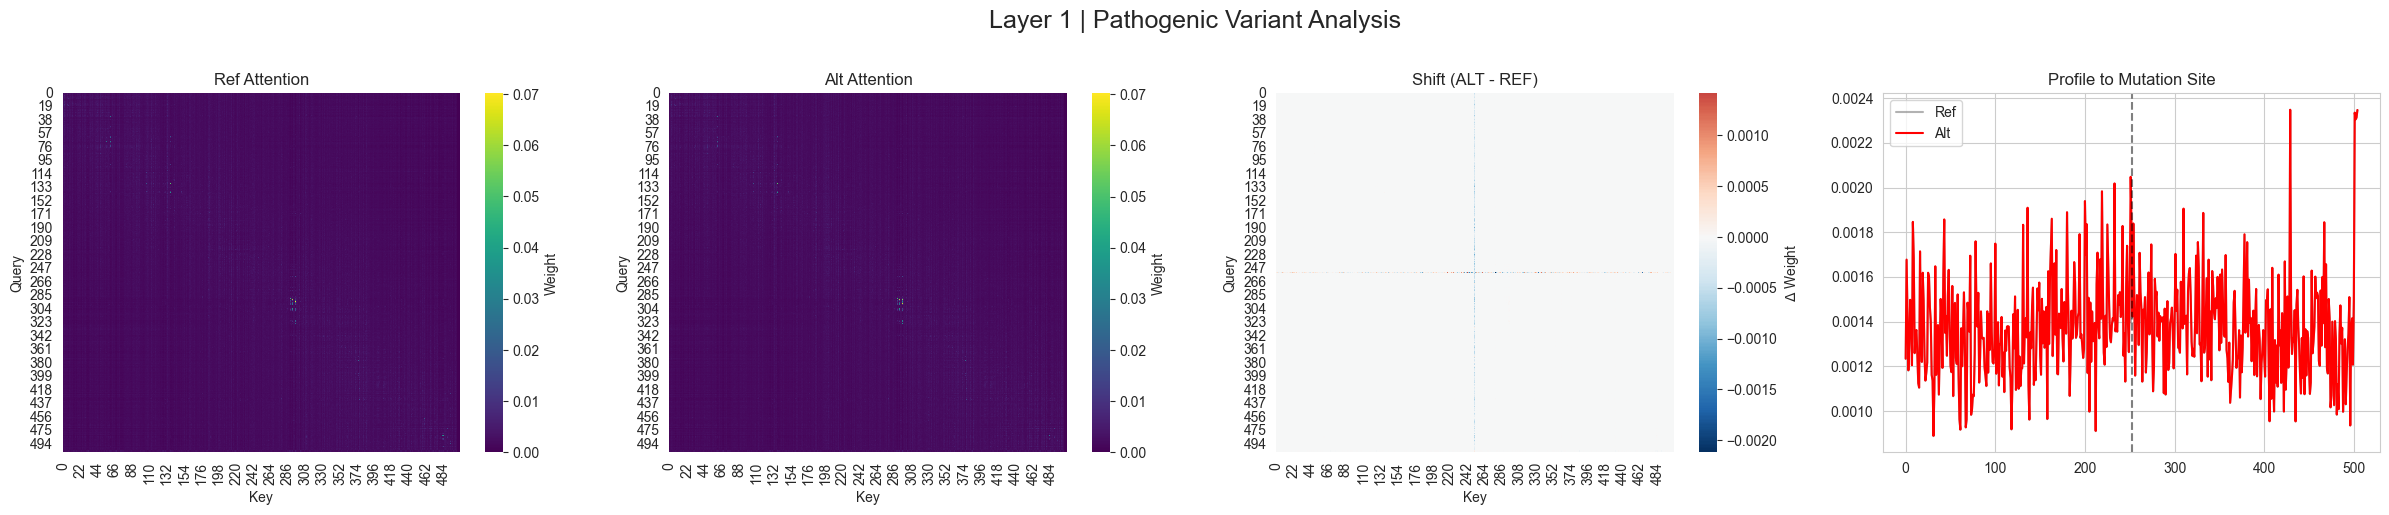

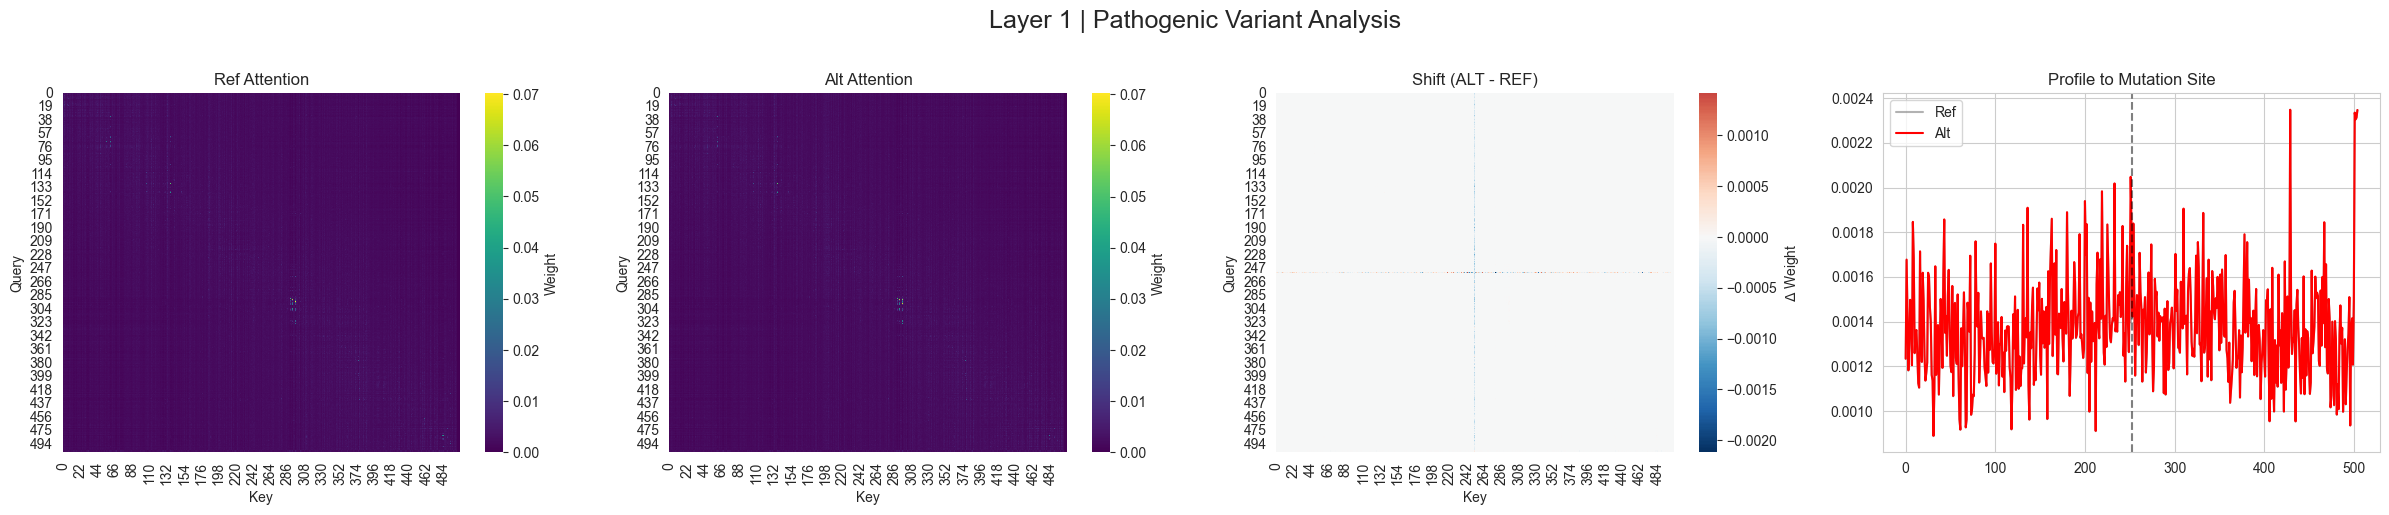

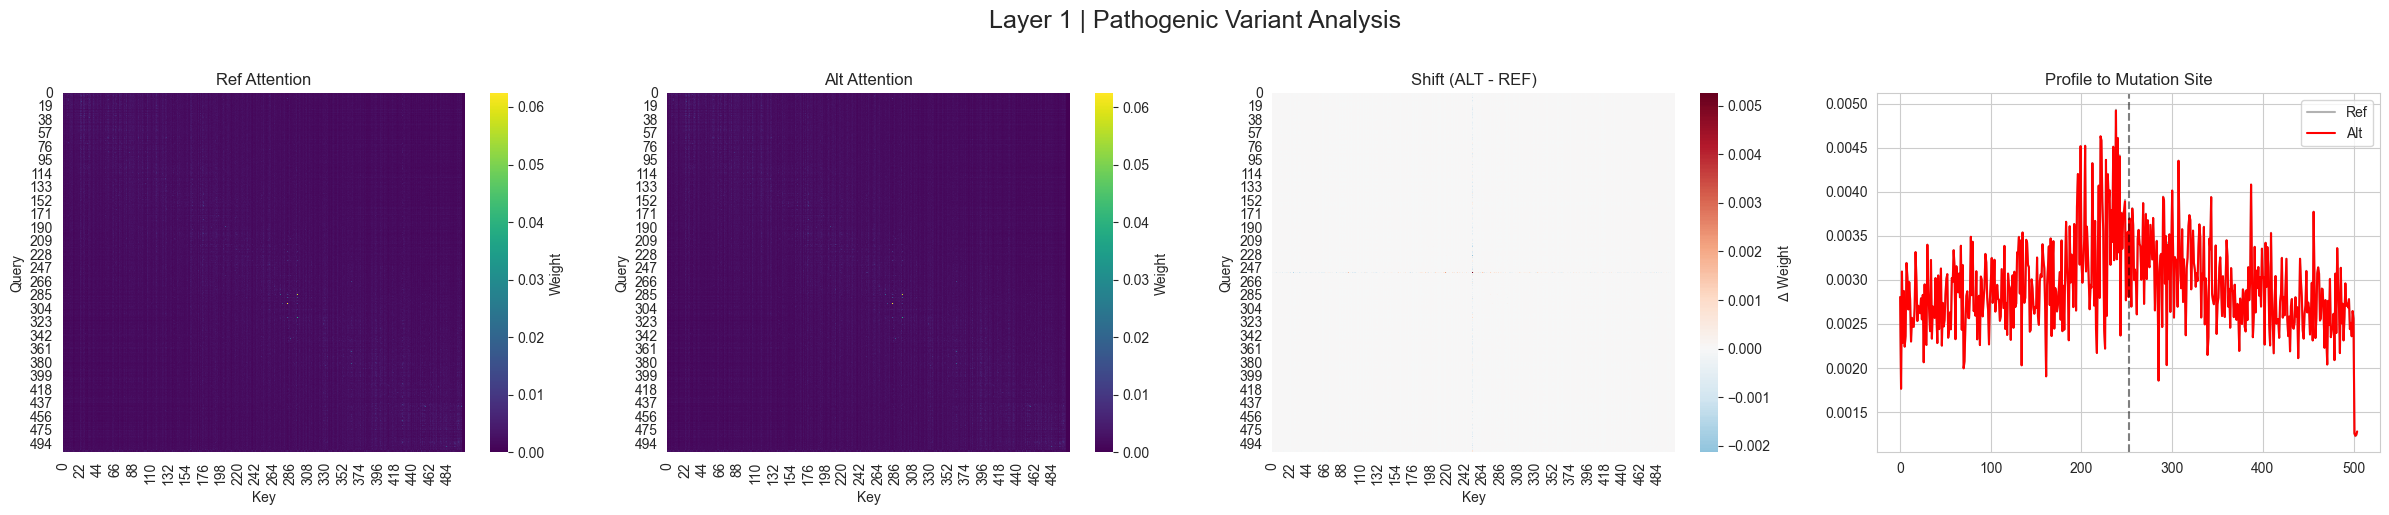

In [24]:
visualize_variant_attention(payload, variant_idx=134, layer=1, label="Pathogenic")
visualize_variant_attention(payload, variant_idx=135, layer=1, label="Pathogenic")
visualize_variant_attention(payload, variant_idx=136, layer=1, label="Pathogenic")
visualize_variant_attention(payload, variant_idx=137, layer=1, label="Pathogenic")

#### BENIGN LAYER 9

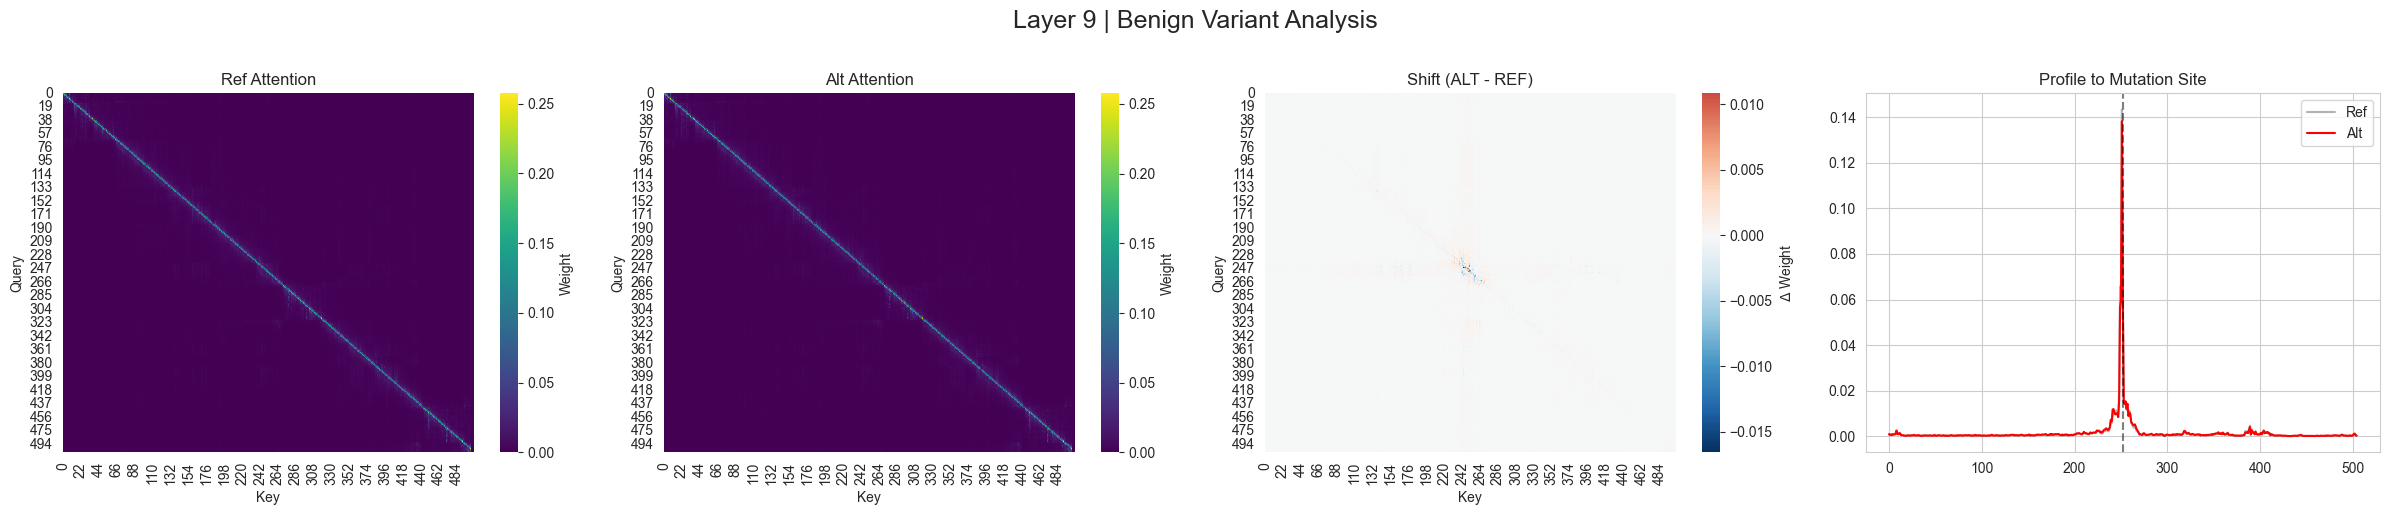

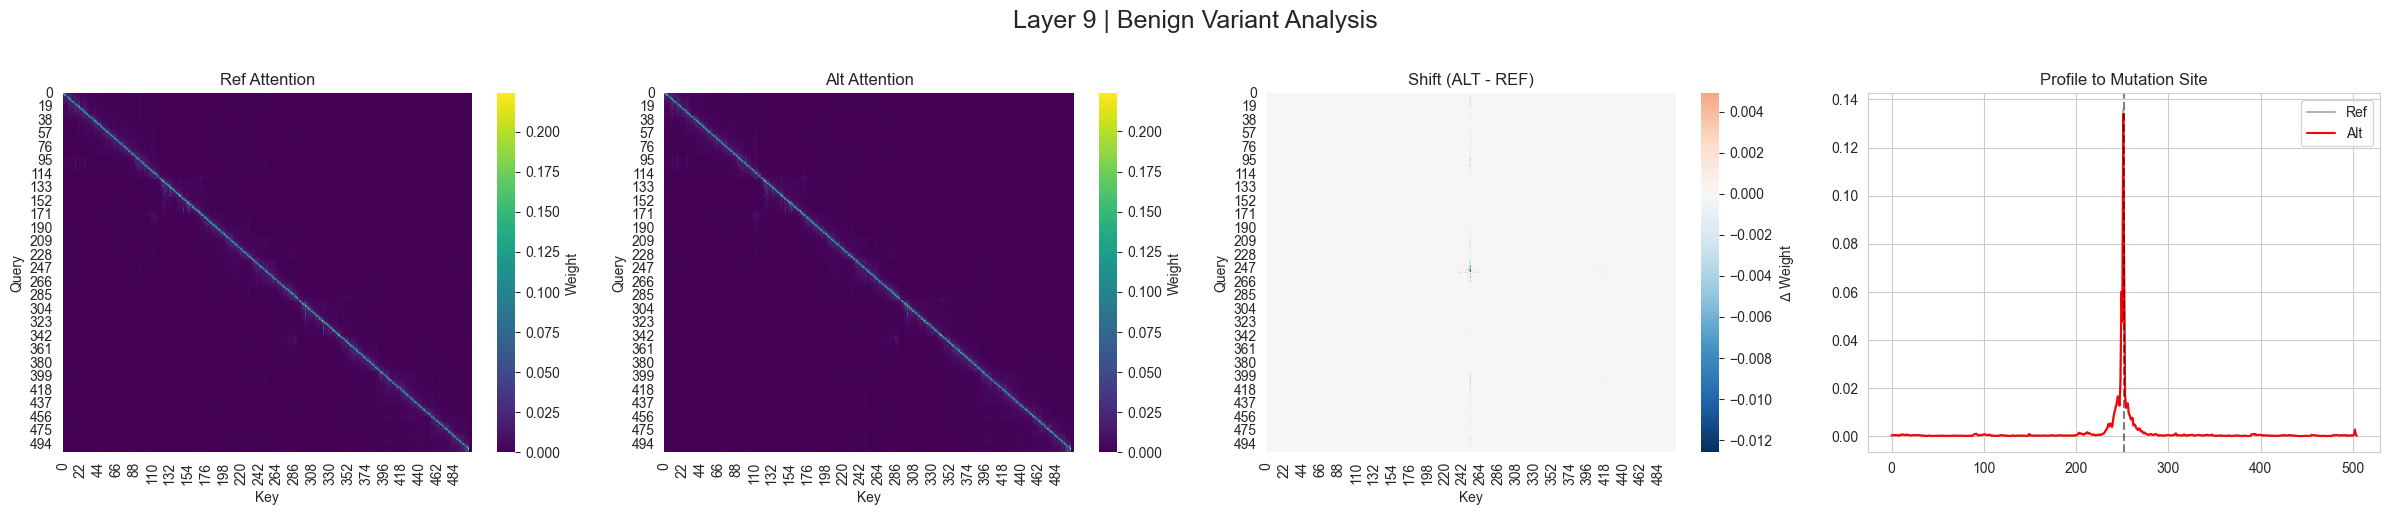

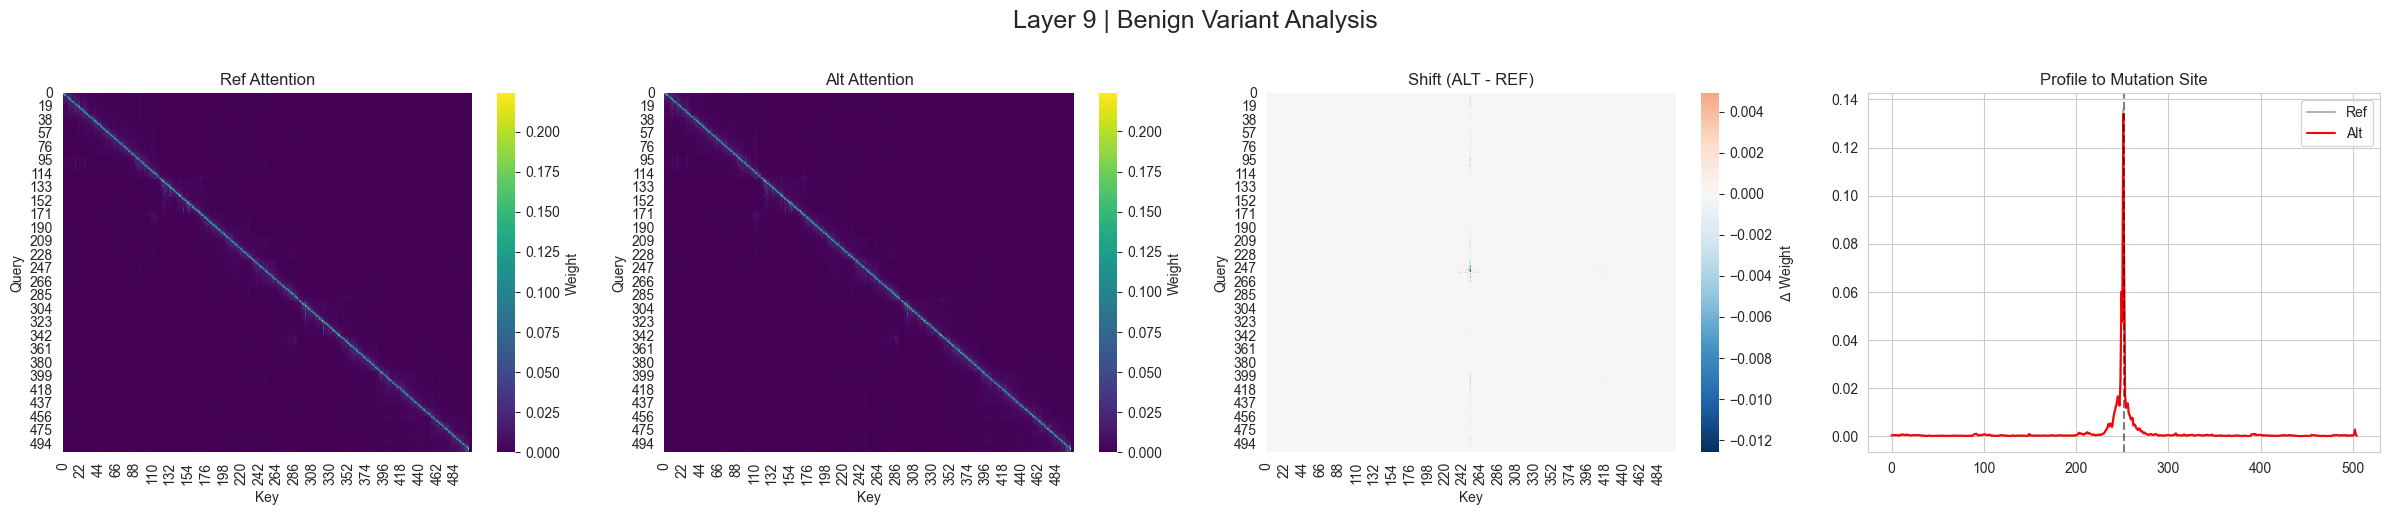

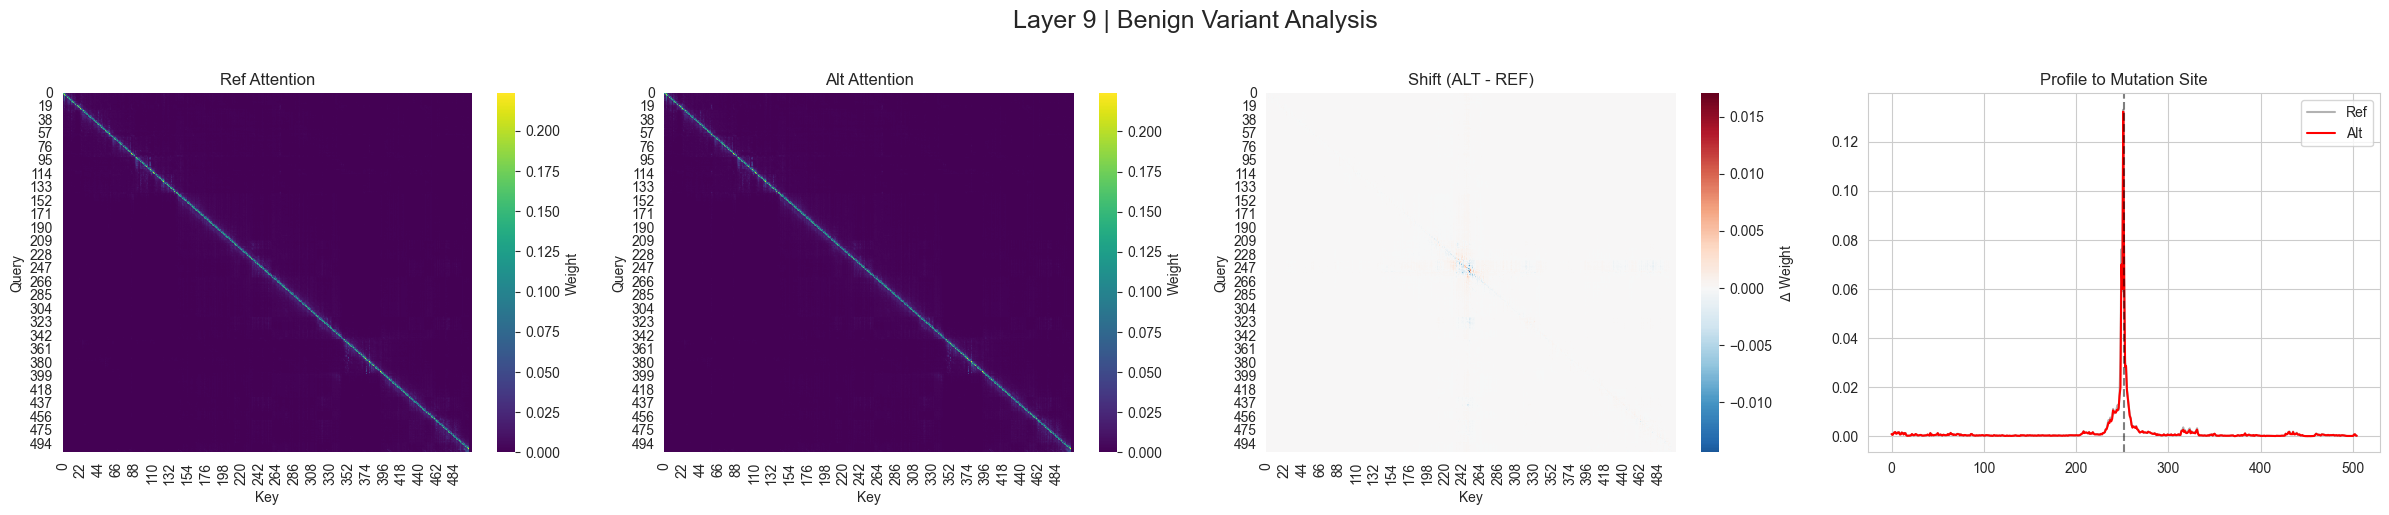

In [26]:
visualize_variant_attention(payload, variant_idx=1, layer=9, label="Benign")
visualize_variant_attention(payload, variant_idx=2, layer=9, label="Benign")
visualize_variant_attention(payload, variant_idx=3, layer=9, label="Benign")
visualize_variant_attention(payload, variant_idx=4, layer=9, label="Benign")

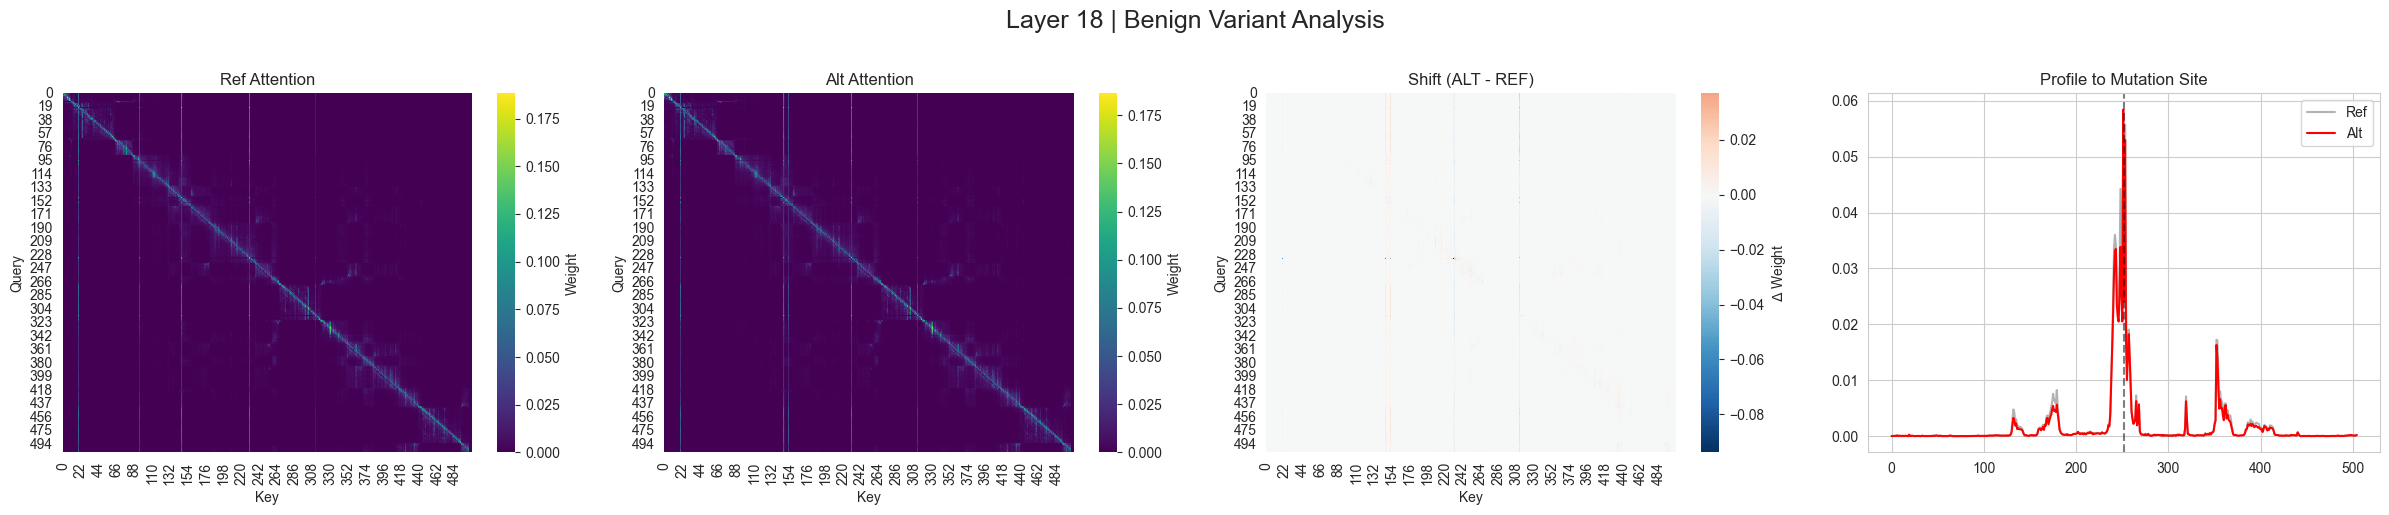

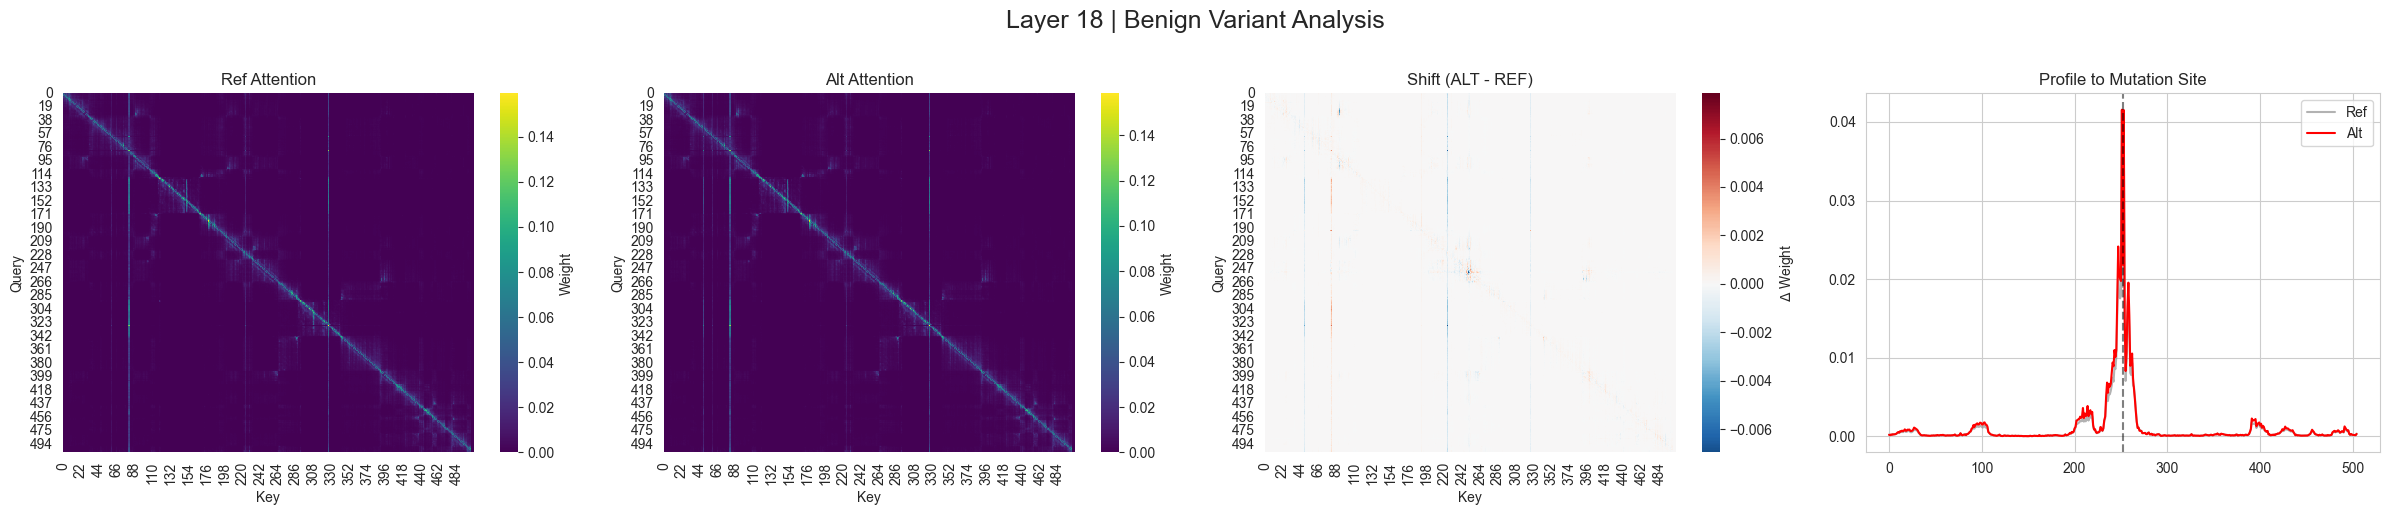

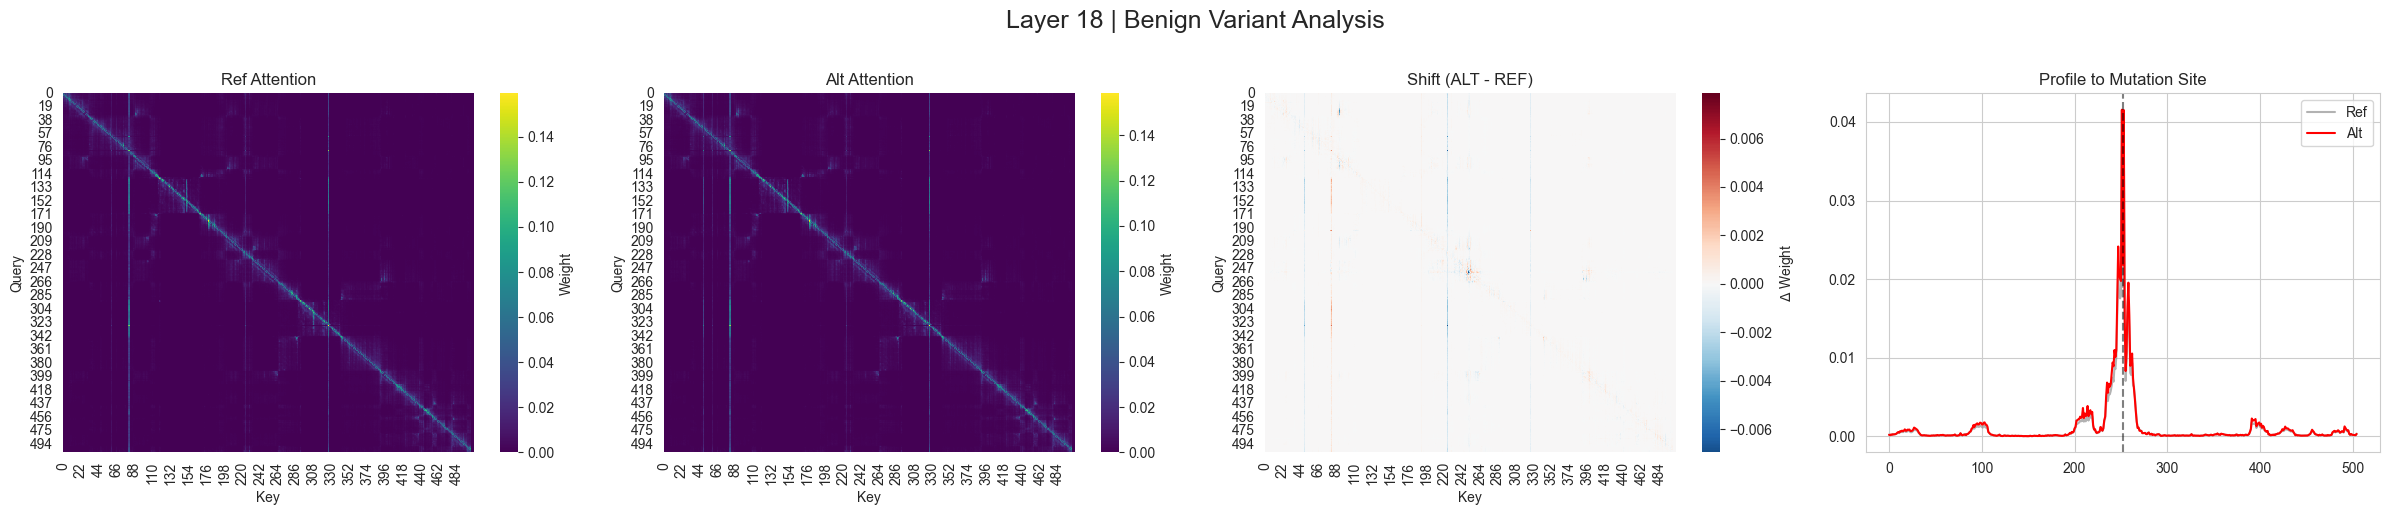

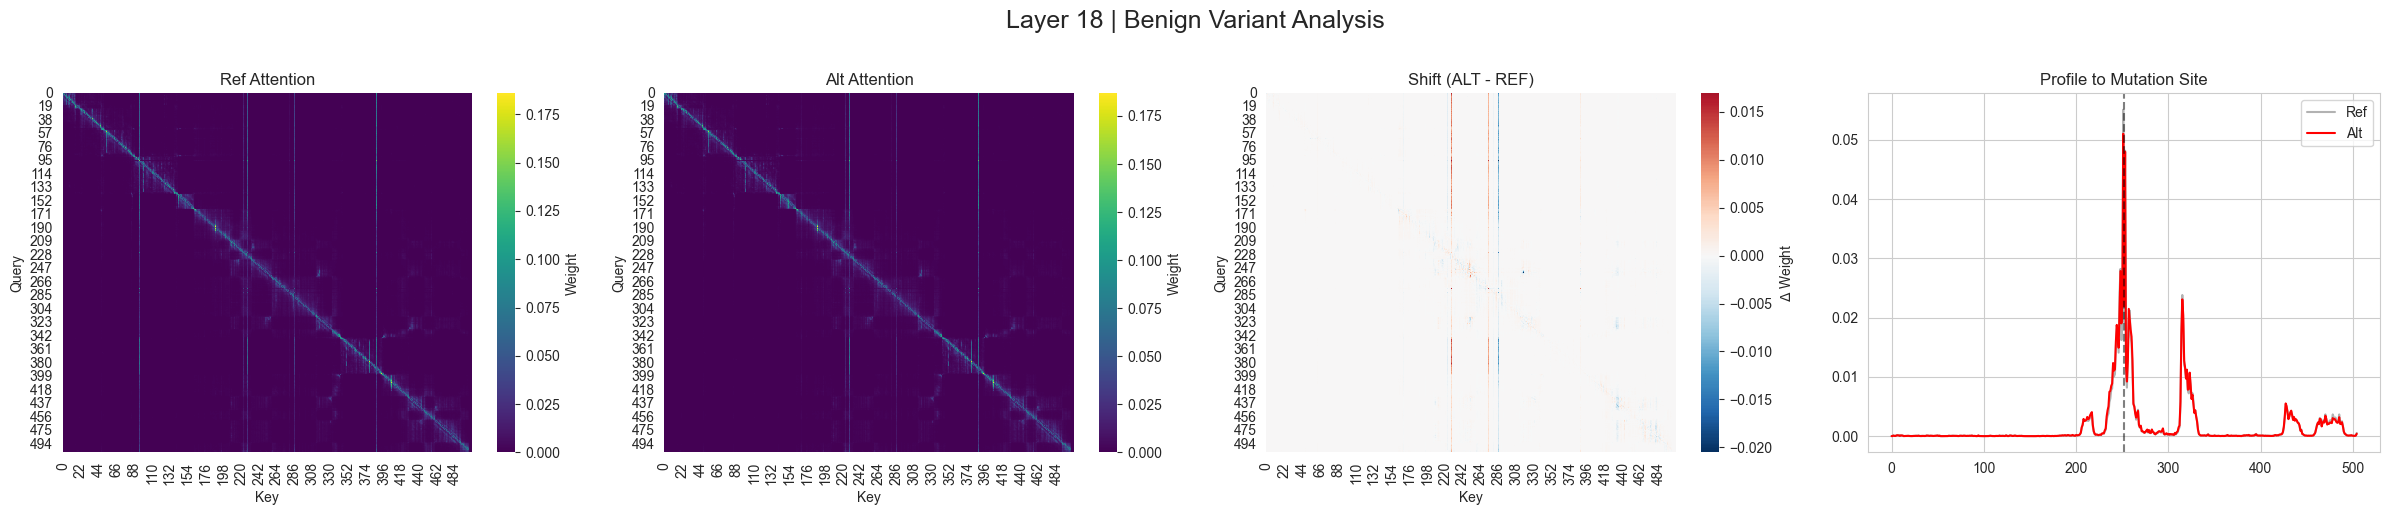

In [25]:
visualize_variant_attention(payload, variant_idx=1, layer=18, label="Benign")
visualize_variant_attention(payload, variant_idx=2, layer=18, label="Benign")
visualize_variant_attention(payload, variant_idx=3, layer=18, label="Benign")
visualize_variant_attention(payload, variant_idx=4, layer=18, label="Benign")

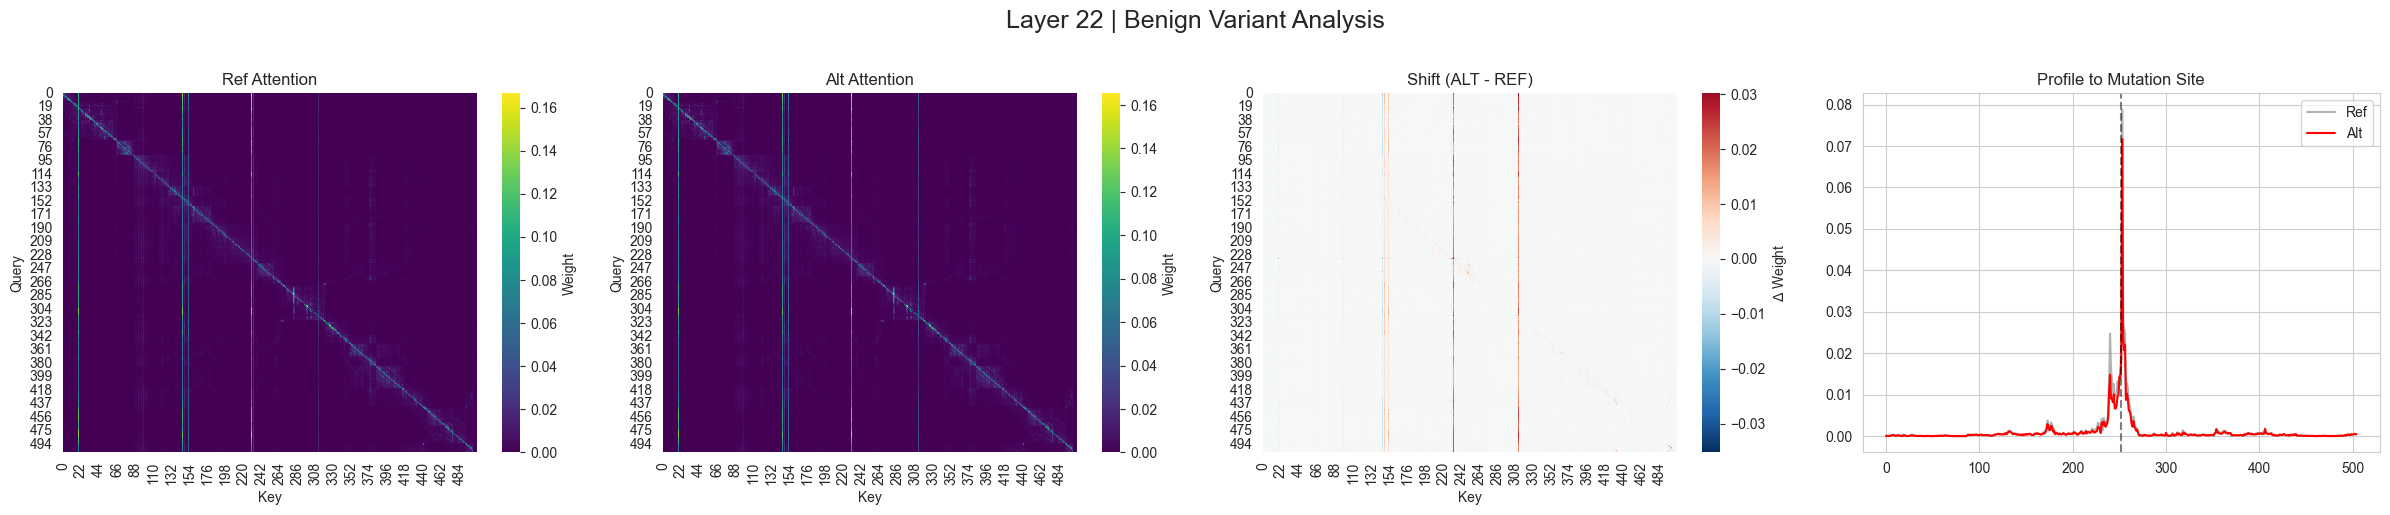

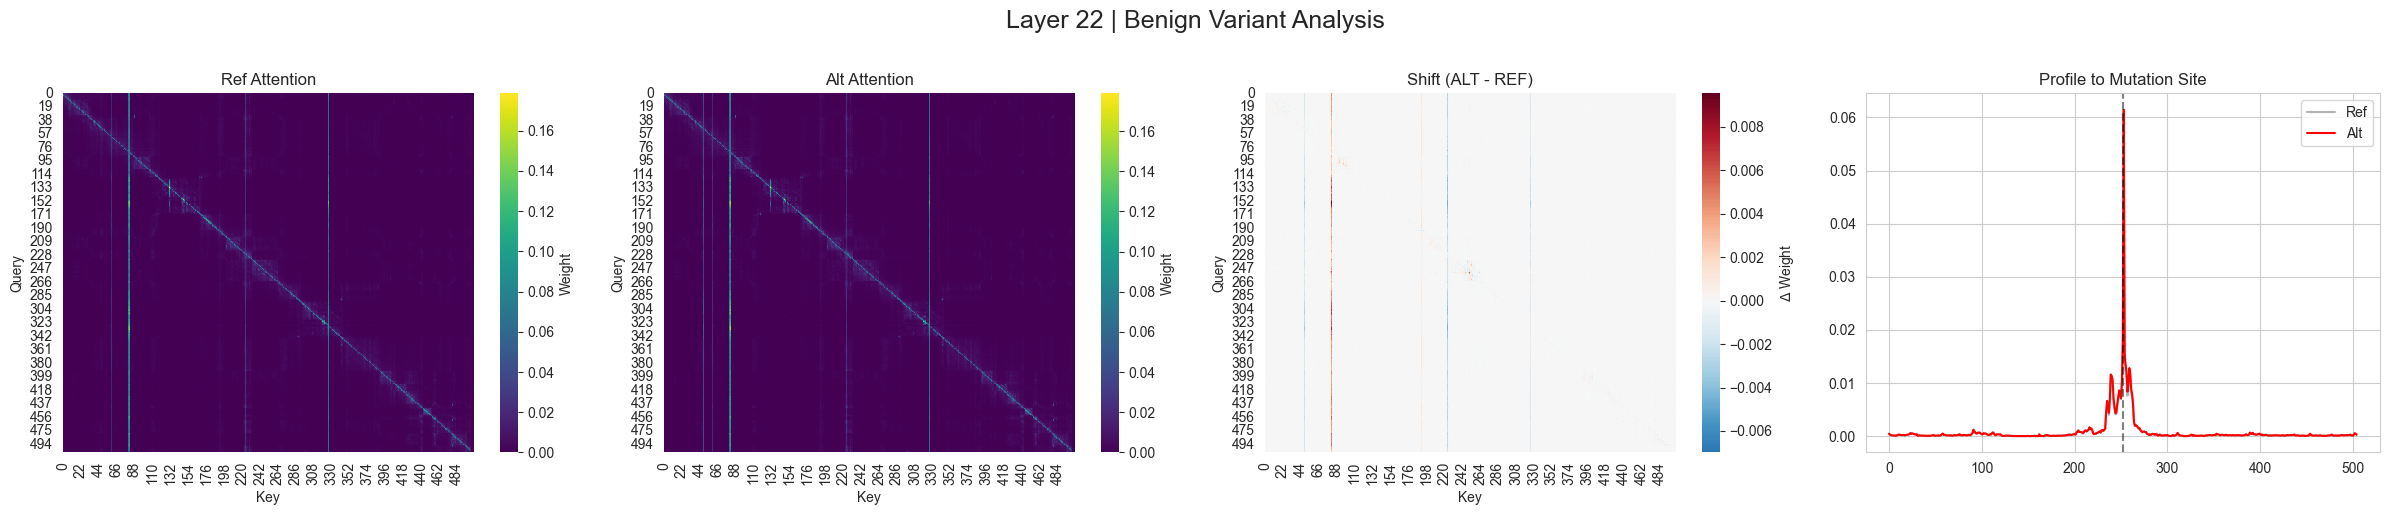

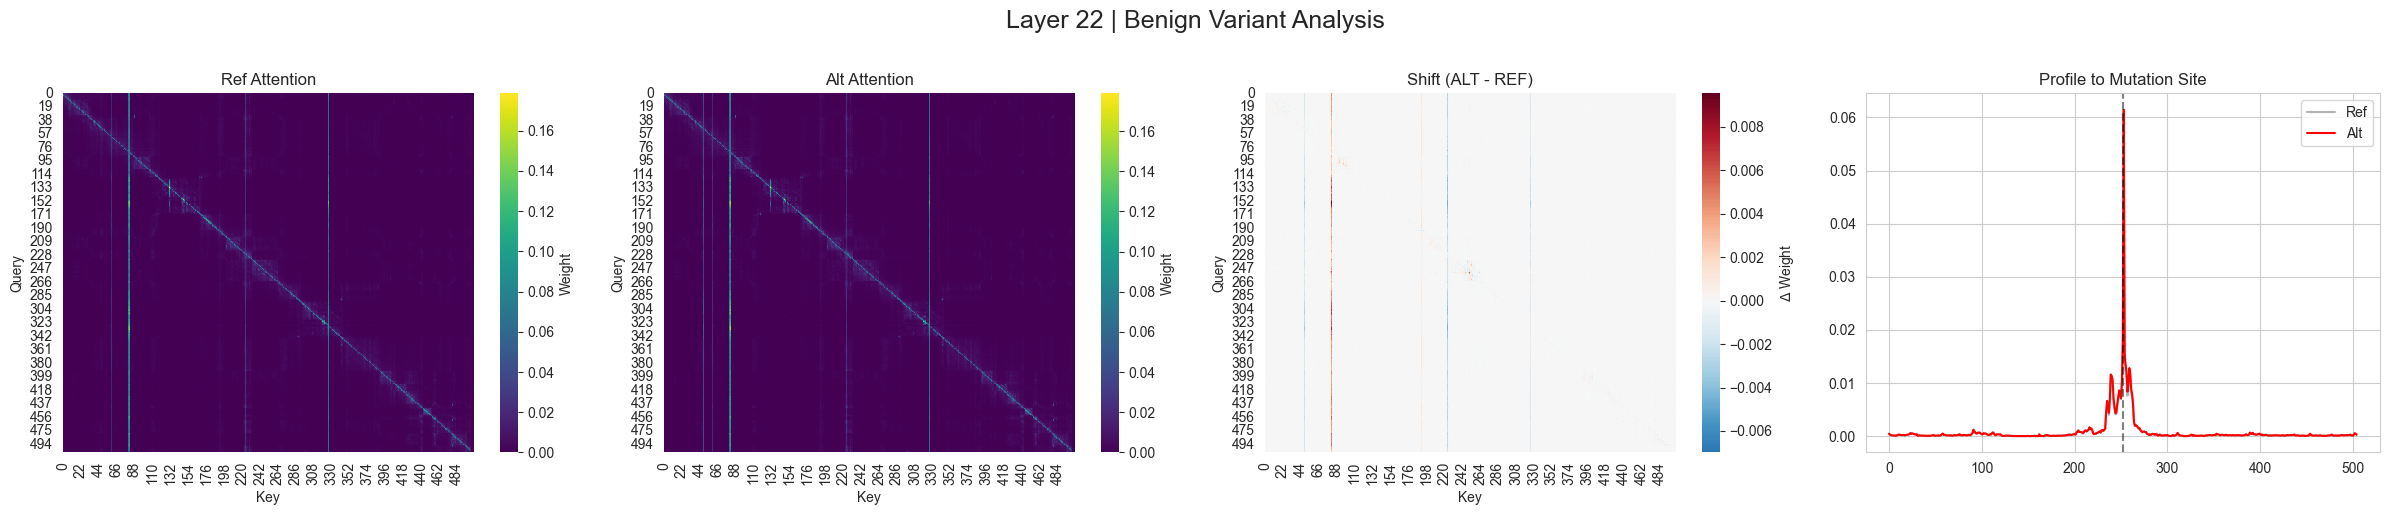

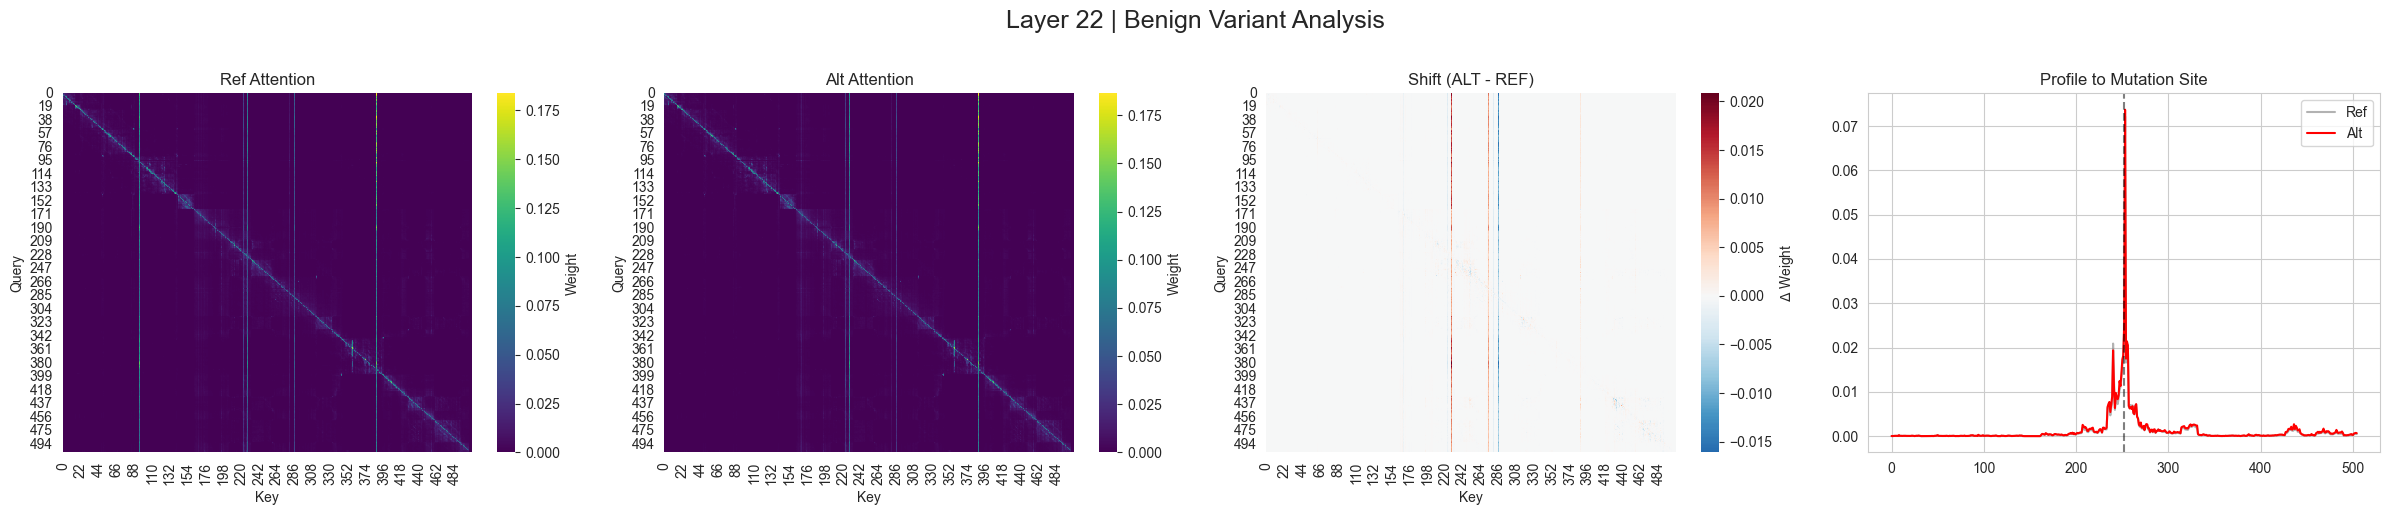

In [27]:
visualize_variant_attention(payload, variant_idx=1, layer=22, label="Benign")
visualize_variant_attention(payload, variant_idx=2, layer=22, label="Benign")
visualize_variant_attention(payload, variant_idx=3, layer=22, label="Benign")
visualize_variant_attention(payload, variant_idx=4, layer=22, label="Benign")

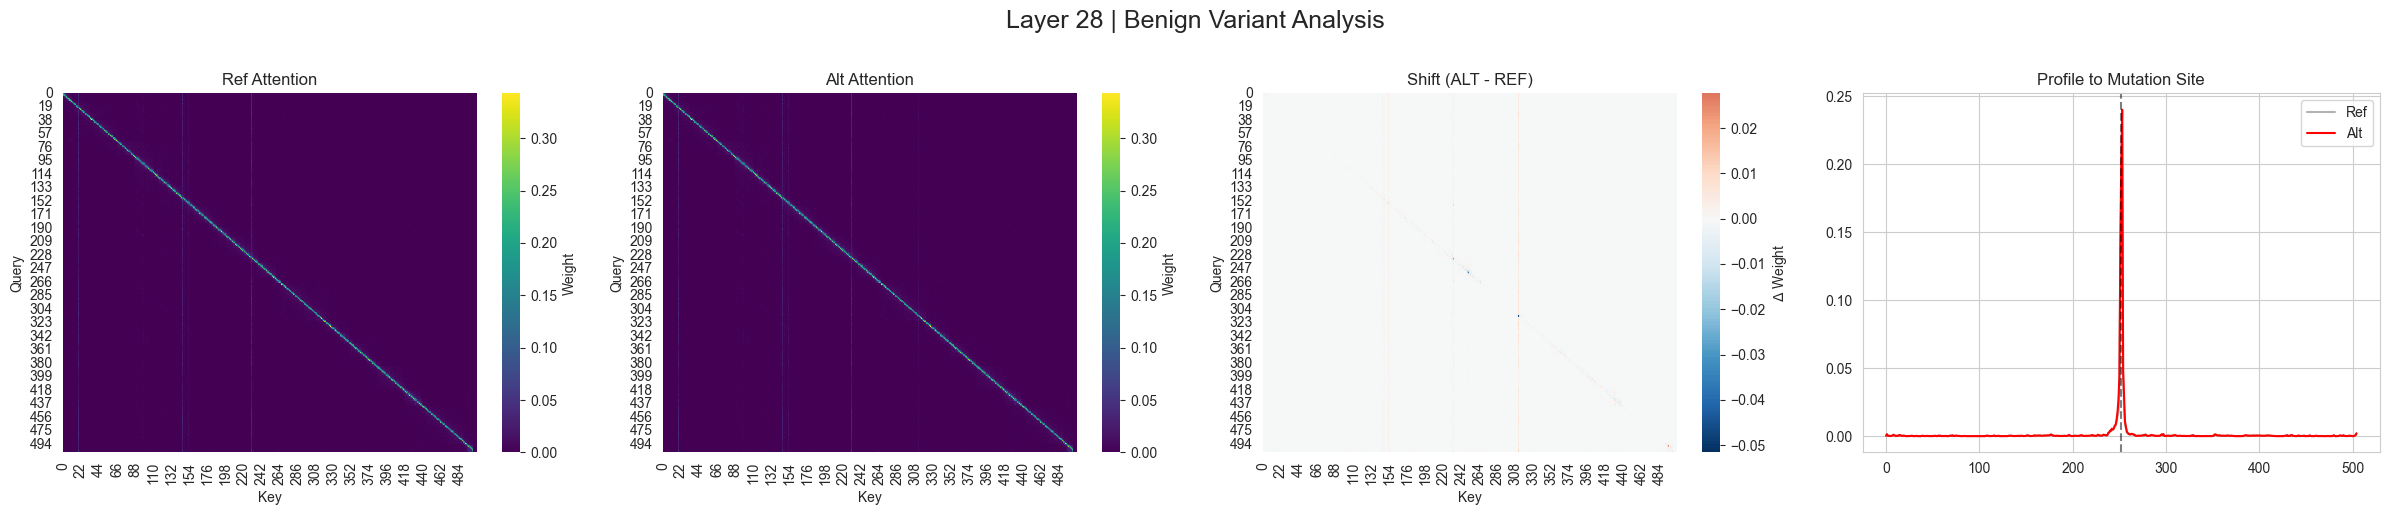

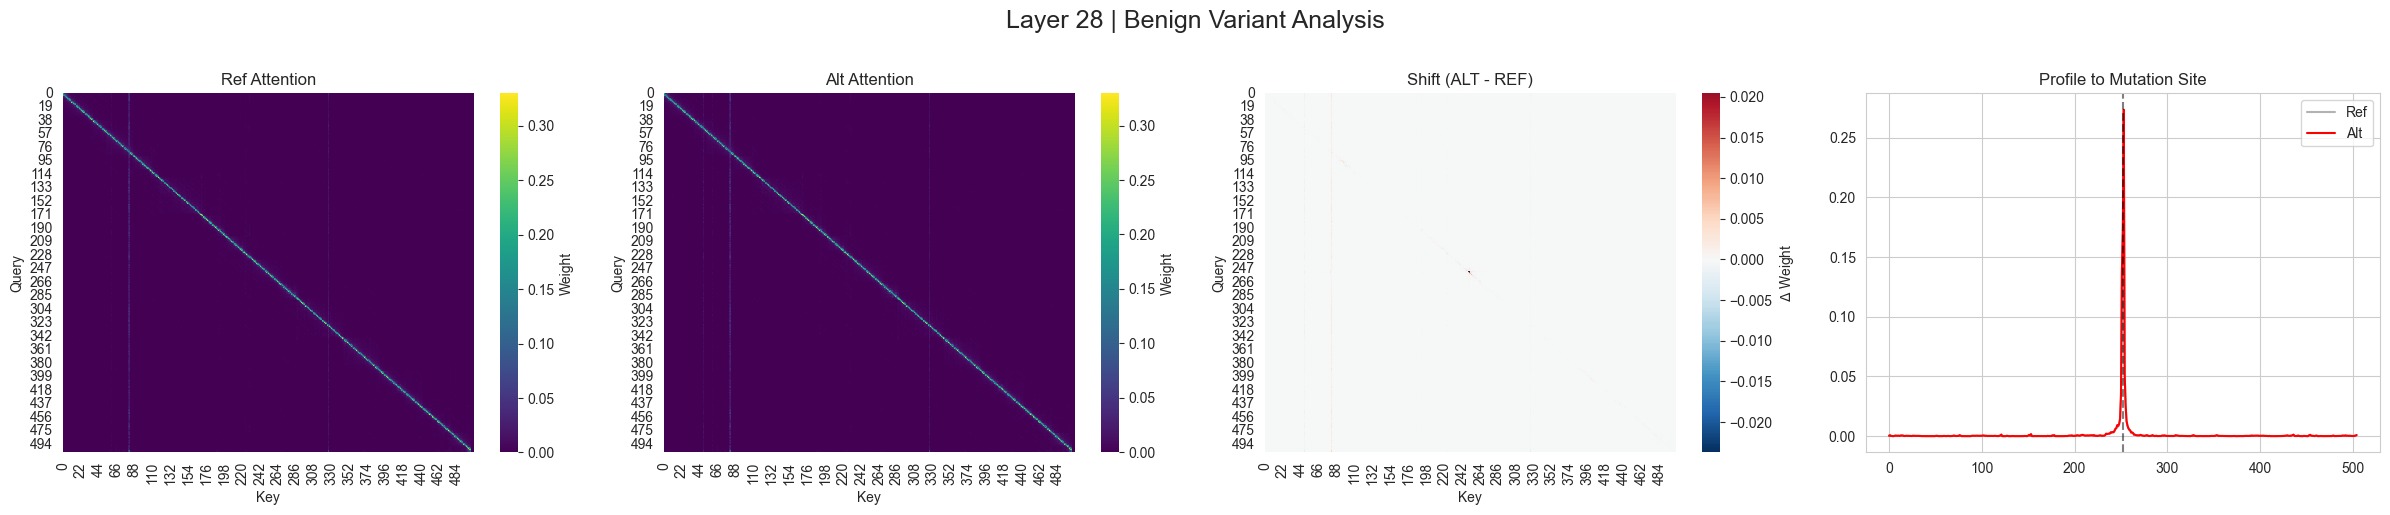

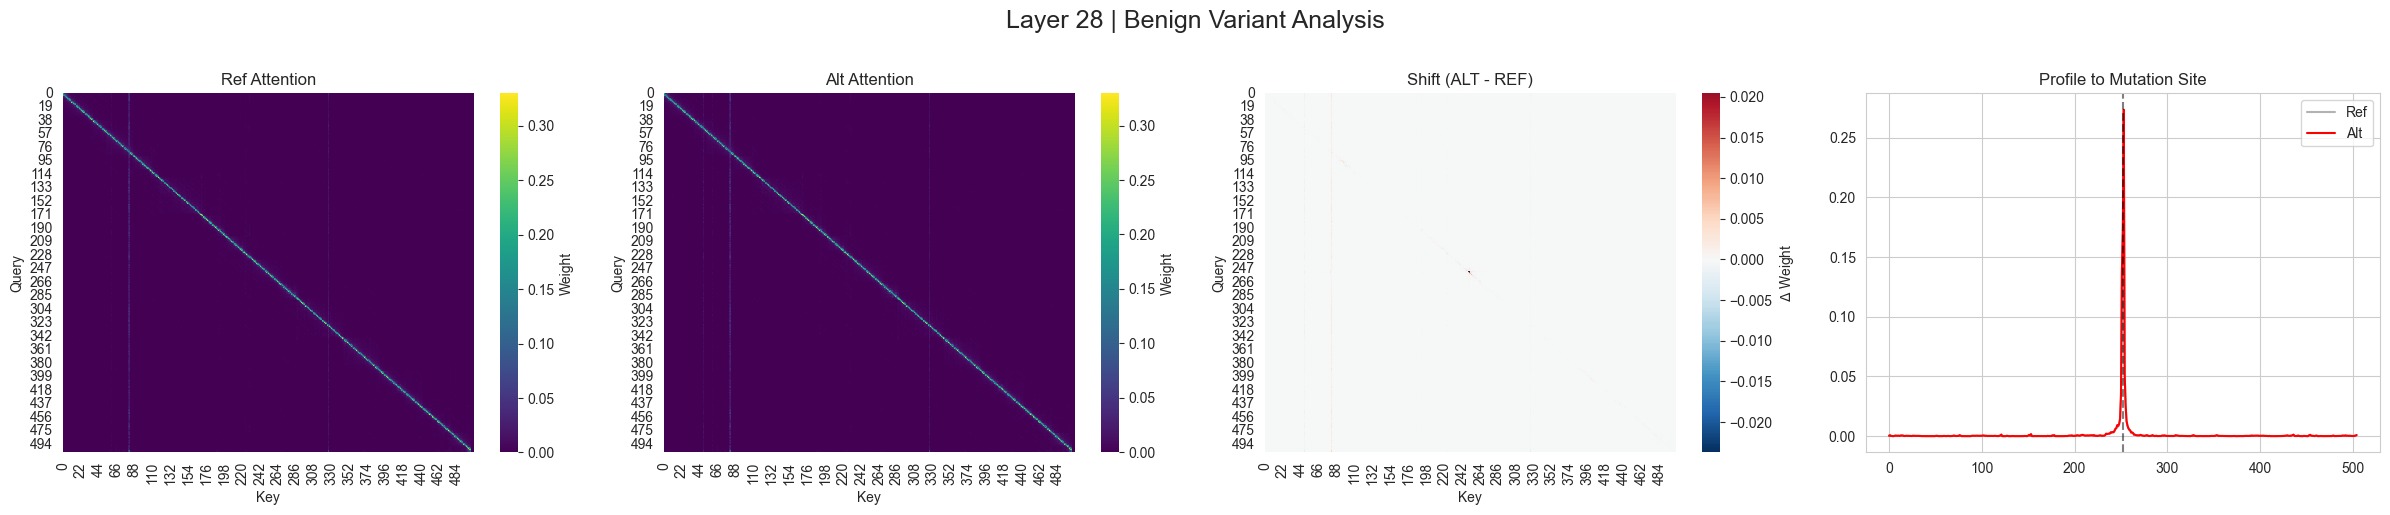

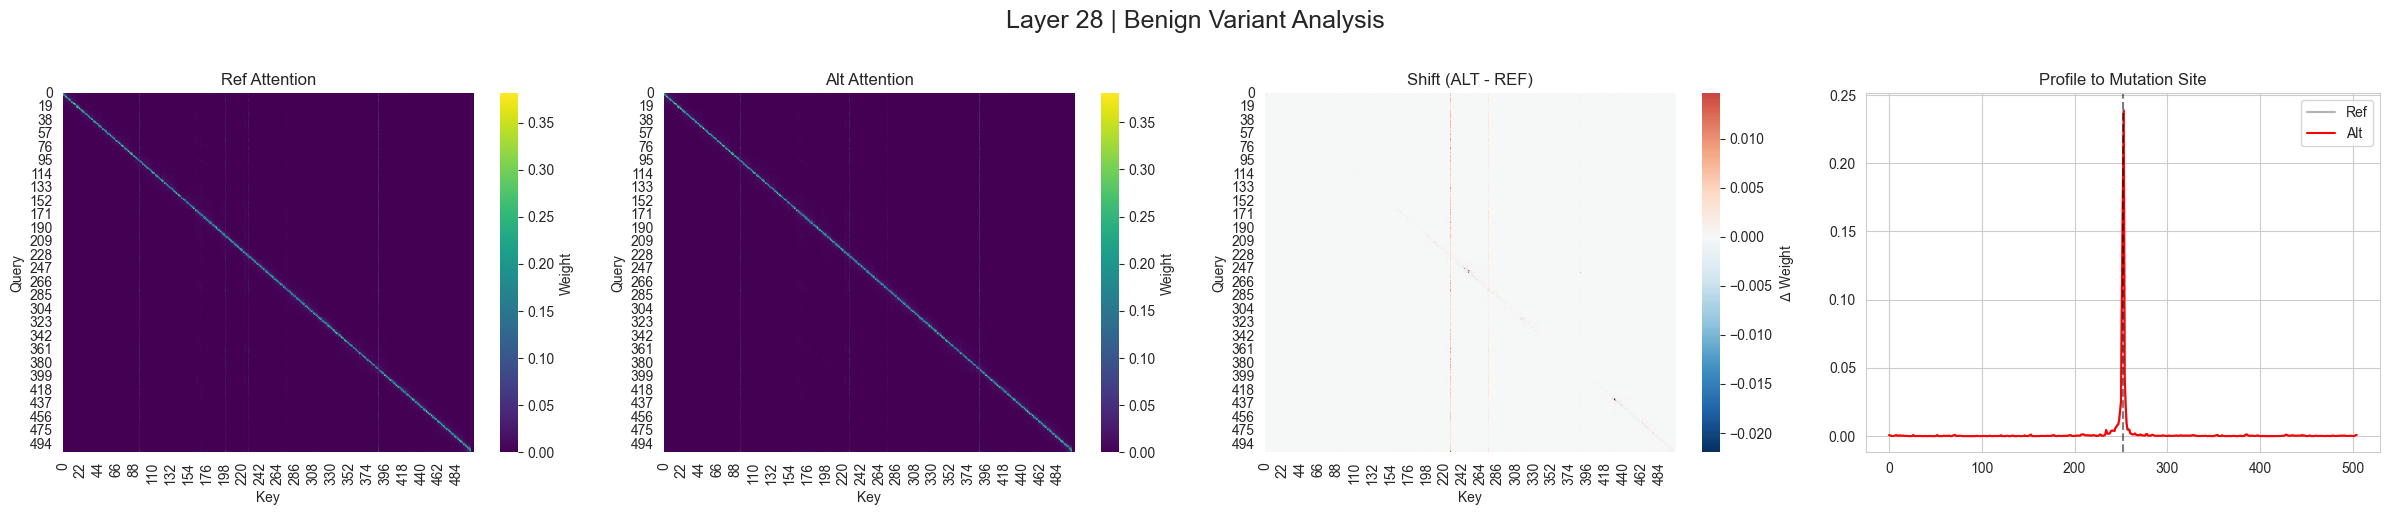

In [28]:
visualize_variant_attention(payload, variant_idx=1, layer=28, label="Benign")
visualize_variant_attention(payload, variant_idx=2, layer=28, label="Benign")
visualize_variant_attention(payload, variant_idx=3, layer=28, label="Benign")
visualize_variant_attention(payload, variant_idx=4, layer=28, label="Benign")

/var/folders/zb/p41gp_m56t14dq5sdzffcz9m0000gn/T/ipykernel_90375/1113866683.py:104: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


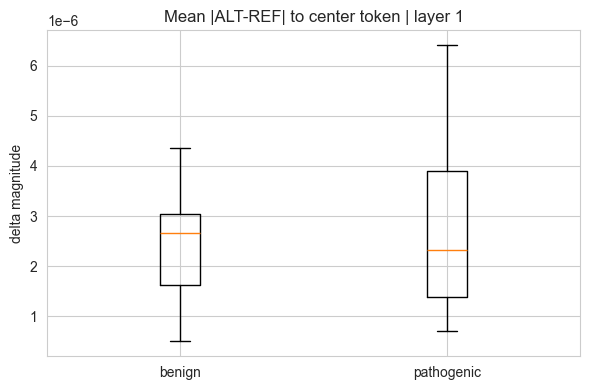

Layer 1: n_benign=54 n_pathogenic=60 median_benign=2.661e-06 median_pathogenic=2.324e-06


/var/folders/zb/p41gp_m56t14dq5sdzffcz9m0000gn/T/ipykernel_90375/1113866683.py:104: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


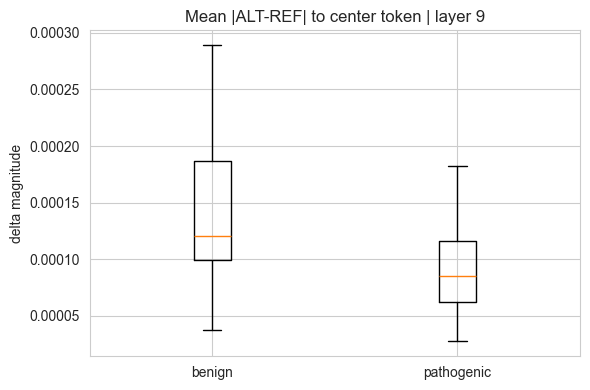

Layer 9: n_benign=54 n_pathogenic=60 median_benign=0.0001204 median_pathogenic=8.519e-05


/var/folders/zb/p41gp_m56t14dq5sdzffcz9m0000gn/T/ipykernel_90375/1113866683.py:104: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


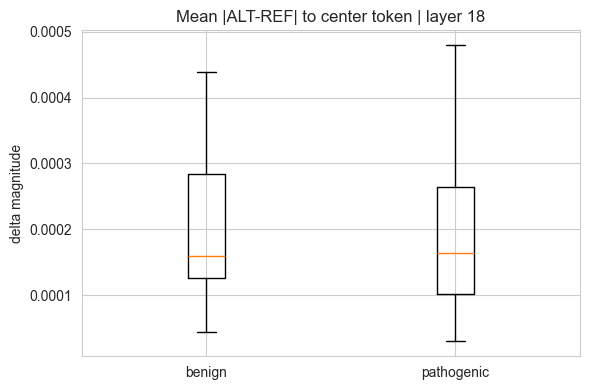

Layer 18: n_benign=54 n_pathogenic=60 median_benign=0.0001594 median_pathogenic=0.0001647


/var/folders/zb/p41gp_m56t14dq5sdzffcz9m0000gn/T/ipykernel_90375/1113866683.py:104: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


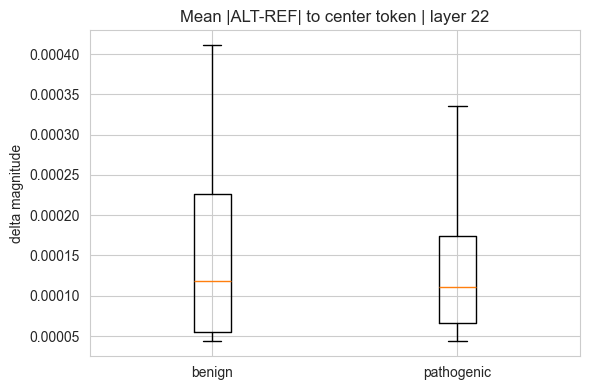

Layer 22: n_benign=54 n_pathogenic=60 median_benign=0.0001185 median_pathogenic=0.000111


/var/folders/zb/p41gp_m56t14dq5sdzffcz9m0000gn/T/ipykernel_90375/1113866683.py:104: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


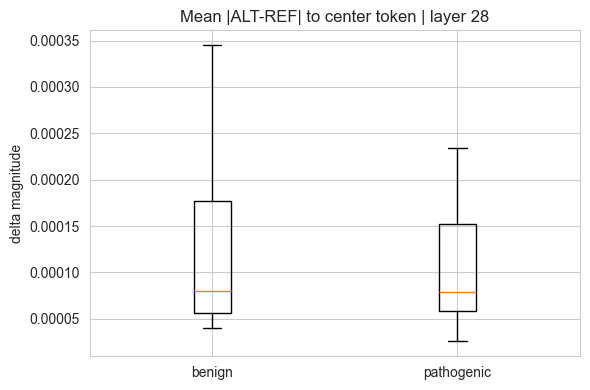

Layer 28: n_benign=54 n_pathogenic=60 median_benign=7.984e-05 median_pathogenic=7.899e-05
Layer 1: Mann–Whitney U=1.56e+03, z=-0.369, p≈0.712 (n_benign=54, n_pathogenic=60)
Layer 9: Mann–Whitney U=977, z=-3.65, p≈0.000263 (n_benign=54, n_pathogenic=60)
Layer 18: Mann–Whitney U=1.57e+03, z=-0.284, p≈0.777 (n_benign=54, n_pathogenic=60)
Layer 22: Mann–Whitney U=1.61e+03, z=-0.0738, p≈0.941 (n_benign=54, n_pathogenic=60)
Layer 28: Mann–Whitney U=1.51e+03, z=-0.619, p≈0.536 (n_benign=54, n_pathogenic=60)


In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import math

# -----------------------------
# 1) Helpers
# -----------------------------
def label_to_group(y):
    s = str(y).strip().lower()

    if s == "class 1":
        return "benign"
    if s == "class 5":
        return "pathogenic"
    return "other"



def center_delta_scalar(A_ref, A_alt, m, mode="mean_abs", axis="col"):
    """
    A_ref, A_alt: (L, L) numpy arrays
    m: mutation token index
    axis:
      - "col": attention TO mutation key (others -> mutation)
      - "row": attention FROM mutation query (mutation -> others)
    mode:
      - "mean_abs": mean(|delta|)
      - "signed_mean": mean(delta)
      - "max_abs": max(|delta|)
    """
    if axis == "col":
        ref_vec = A_ref[:, m]
        alt_vec = A_alt[:, m]
    elif axis == "row":
        ref_vec = A_ref[m, :]
        alt_vec = A_alt[m, :]
    else:
        raise ValueError("axis must be 'col' or 'row'")

    delta = alt_vec - ref_vec

    if mode == "mean_abs":
        return float(np.mean(np.abs(delta)))
    if mode == "signed_mean":
        return float(np.mean(delta))
    if mode == "max_abs":
        return float(np.max(np.abs(delta)))

    raise ValueError("mode must be 'mean_abs', 'signed_mean', or 'max_abs'")


# -----------------------------
# 2) Compute per-variant scalars
# -----------------------------
def compute_center_deltas(payload, layers, axis="col", mode="mean_abs"):
    """
    Returns:
      results[layer]["benign"] = list of scalars
      results[layer]["pathogenic"] = list of scalars
      results[layer]["other"] = list of scalars
    """
    labels = payload["labels"]
    N = len(labels)

    results = {l: {"benign": [], "pathogenic": [], "other": []} for l in layers}

    for l in layers:
        A_all = payload["attentions_by_layer"][l]  # torch tensor, shape (2N, L, L) in head_mode='mean'
        if isinstance(A_all, torch.Tensor):
            A_all = A_all.cpu()

        # token length for this layer
        L = A_all.shape[-1]
        m = L // 2  # center token index (matches your assumption)

        for i in range(N):
            grp = label_to_group(labels[i])

            A_ref = A_all[i].numpy()
            A_alt = A_all[i + N].numpy()

            val = center_delta_scalar(A_ref, A_alt, m, mode=mode, axis=axis)
            results[l][grp].append(val)

    return results


# -----------------------------
# 3) Plot benign vs pathogenic
# -----------------------------
def plot_group_comparison(results, layers, title_prefix="Center-delta"):
    """
    Simple boxplot per layer comparing benign vs pathogenic.
    """
    for l in layers:
        benign = results[l]["benign"]
        patho  = results[l]["pathogenic"]

        data = [benign, patho]
        labels = ["benign", "pathogenic"]

        plt.figure(figsize=(6, 4))
        plt.boxplot(data, labels=labels, showfliers=False)
        plt.title(f"{title_prefix} | layer {l}")
        plt.ylabel("delta magnitude")
        plt.tight_layout()
        plt.show()

        print(f"Layer {l}: n_benign={len(benign)} n_pathogenic={len(patho)} "
              f"median_benign={np.median(benign) if benign else np.nan:.4g} "
              f"median_pathogenic={np.median(patho) if patho else np.nan:.4g}")


# -----------------------------
# 4) Mann–Whitney U test (no scipy needed)
# -----------------------------
def mann_whitney_u(x, y):
    """
    Mann–Whitney U with normal approximation (ok for a quick sanity check).
    Returns (U, z, p_two_sided). Handles ties by average ranks.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    n1, n2 = len(x), len(y)
    if n1 == 0 or n2 == 0:
        return np.nan, np.nan, np.nan

    pooled = np.concatenate([x, y])
    order = np.argsort(pooled)
    ranks = np.empty_like(order, dtype=float)
    ranks[order] = np.arange(1, len(pooled) + 1)

    # tie correction: average ranks for ties
    sorted_vals = pooled[order]
    i = 0
    while i < len(sorted_vals):
        j = i
        while j + 1 < len(sorted_vals) and sorted_vals[j + 1] == sorted_vals[i]:
            j += 1
        if j > i:
            avg = np.mean(ranks[order][i:j+1])
            ranks[order][i:j+1] = avg
        i = j + 1

    r1 = np.sum(ranks[:n1])  # ranks for x are first n1 in pooled concatenation
    U1 = r1 - n1 * (n1 + 1) / 2
    U2 = n1 * n2 - U1
    U = min(U1, U2)

    mu = n1 * n2 / 2
    sigma = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)

    z = (U - mu) / sigma if sigma > 0 else 0.0

    # two-sided p-value from normal approx
    # use erfc for stability: p = 2 * (1 - Phi(|z|)) = erfc(|z| / sqrt(2))
    p = math.erfc(abs(z) / math.sqrt(2))

    return float(U), float(z), p


def run_stats(results, layers):
    for l in layers:
        benign = results[l]["benign"]
        patho  = results[l]["pathogenic"]
        U, z, p = mann_whitney_u(benign, patho)
        print(f"Layer {l}: Mann–Whitney U={U:.3g}, z={z:.3g}, p≈{p:.3g} "
              f"(n_benign={len(benign)}, n_pathogenic={len(patho)})")


# -----------------------------
# 5) Example usage
# -----------------------------
# Choose which definition you want:
# axis="col"  -> others attend TO mutation key (recommended to match your stripe observations)
# axis="row"  -> mutation query attends TO others
# mode="mean_abs" -> robust magnitude
results = compute_center_deltas(payload, layers=[1, 9, 18, 22, 28], axis="col", mode="mean_abs")

plot_group_comparison(results, layers=[1,9, 18,22, 28], title_prefix="Mean |ALT-REF| to center token")
run_stats(results, layers=[1,9, 18,22, 28])
